# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import mode, shapiro, boxcox
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, roc_curve, roc_auc_score

In [3]:
# Start coding here...

data = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/recipe_site_traffic_2212.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


# Data cleaning and validation

Please find below a summary of cleaning and validations steps for every column.
- 'recipe' - This column did not require any cleaning as it contains id numbers of recipes.
- 'calories', 'carbohydrate', 'sugar', 'protein' -  Missing values occuring in all those 4 columns at the same time were dropped. During visual analysis many outliers were found. They were identified using Modified Z-score method and replaced with median counted separately for each category.
- 'category' - There was additional category 'Chicken Breast', which was merged with 'Chicken' category.
- 'servings' - Comment 'as snack' was removed and data type was changed to integer
- 'high_traffic' - Column was encoded - 1 for 'High' traffic value and 0 for null values, which indicated no high traffic. After encoding, the original column was dropped.

More detailed explanations can be found between cells of code and visualisations.

Checking for duplicates:

In [4]:
#checking for duplicates
data.dropna()[data[['calories', 'carbohydrate', 'sugar', 'protein', 'category']].duplicated()].any()

recipe          False
calories        False
carbohydrate    False
sugar           False
protein         False
category        False
servings        False
high_traffic    False
dtype: bool

Exploring null values and patterns in the missingness - values are sorted by 'calories' column

<AxesSubplot: >

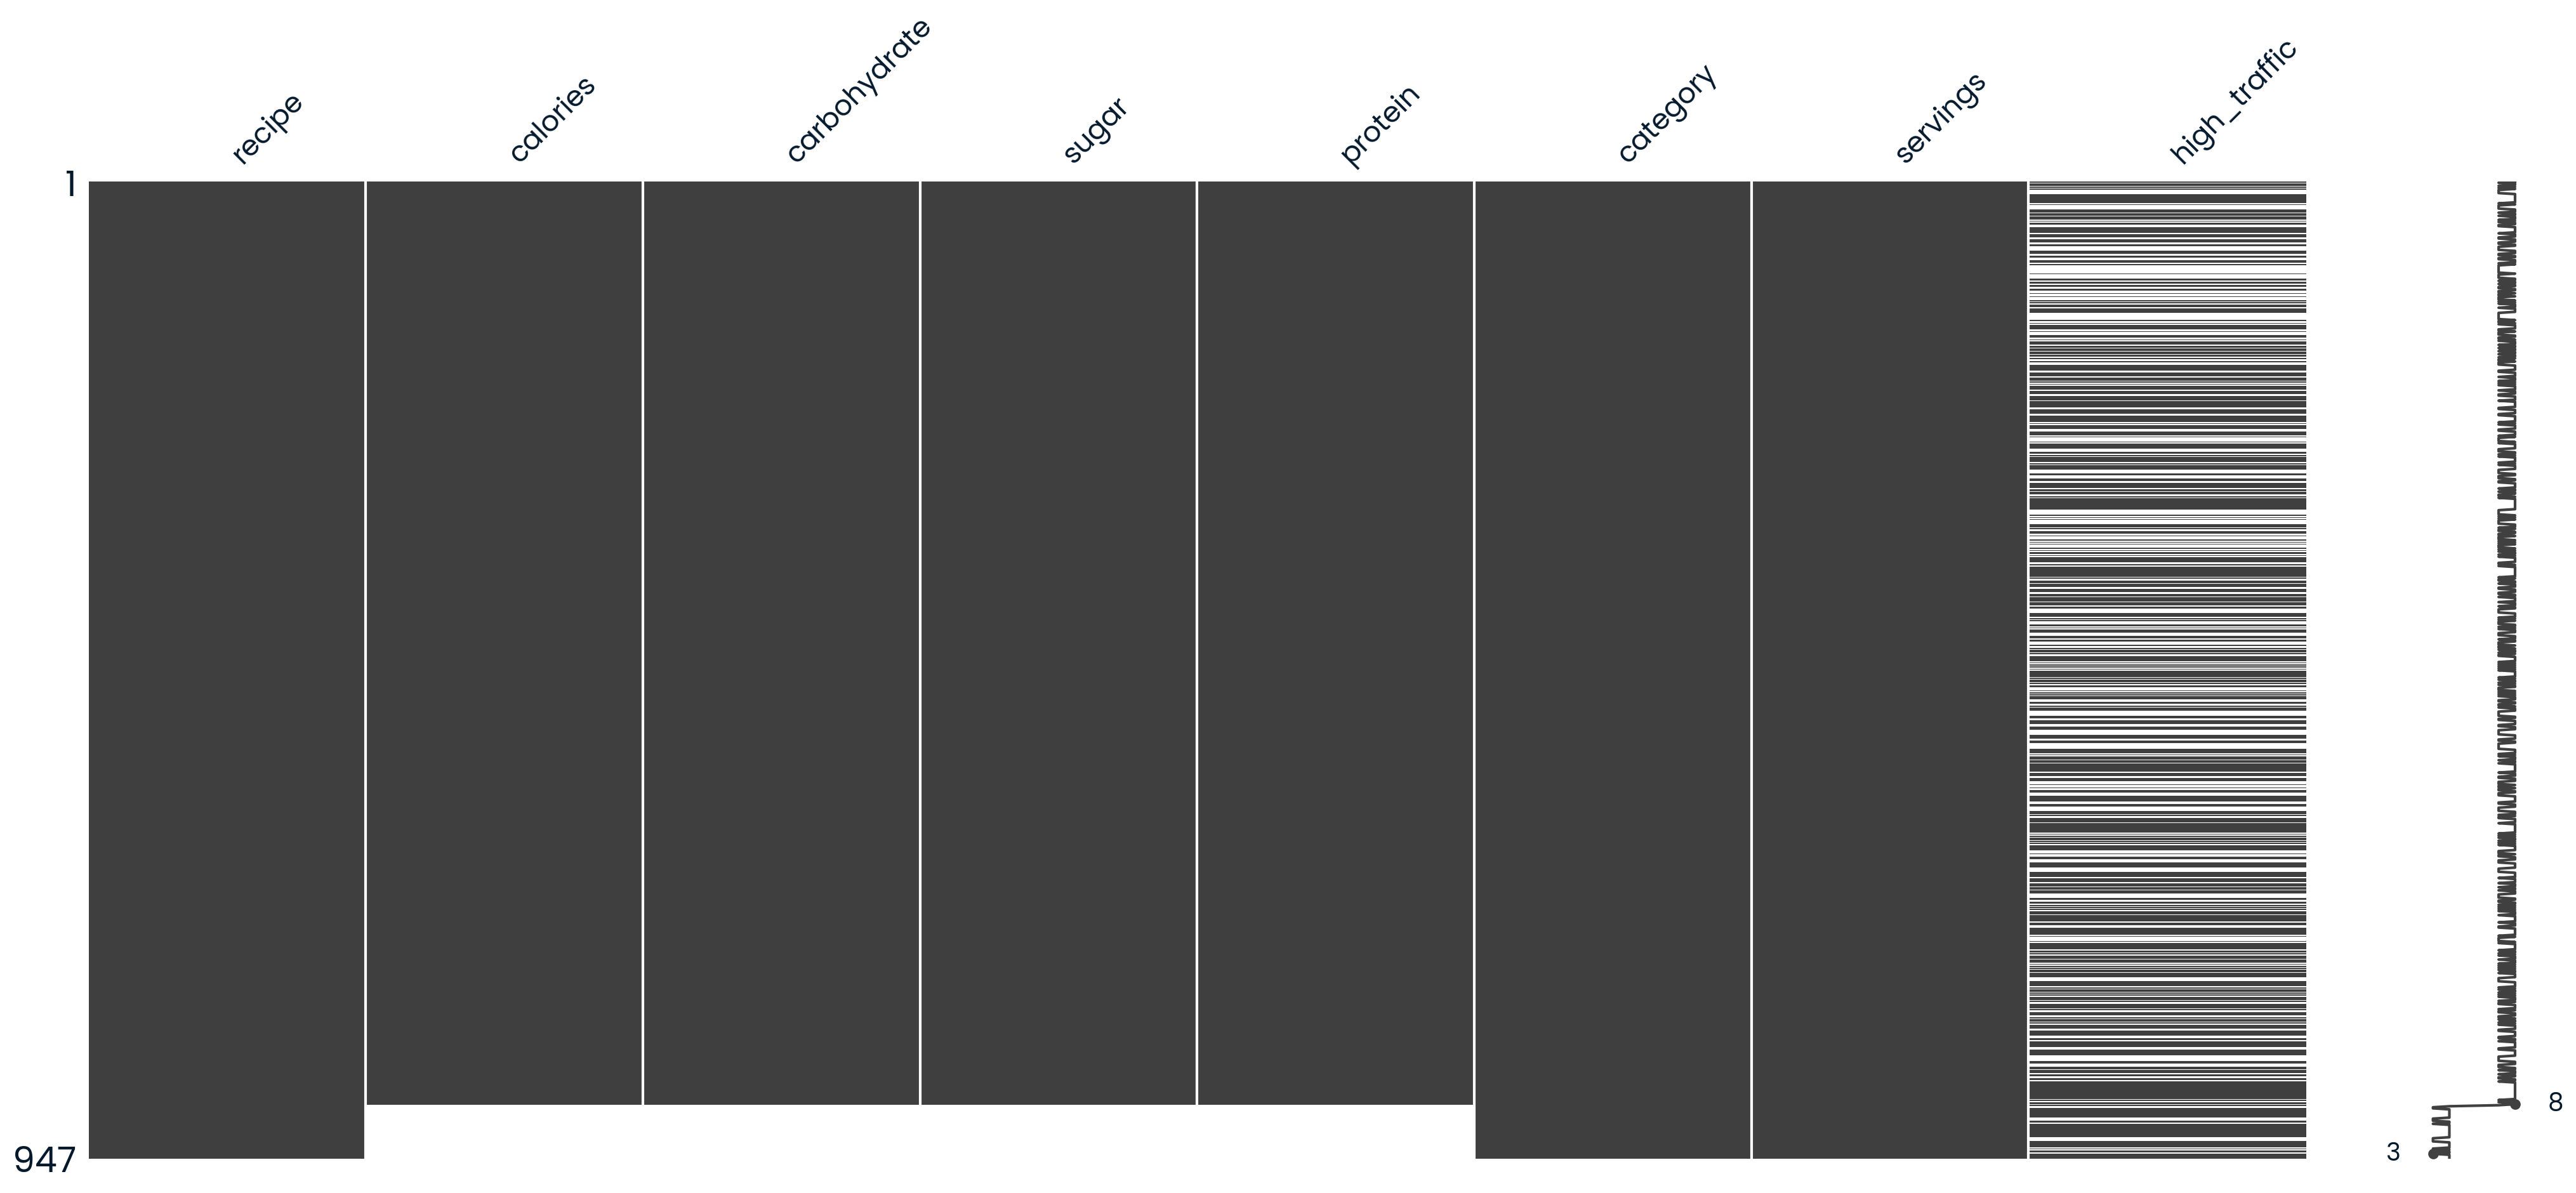

In [5]:
msno.matrix(data.sort_values('calories'))

In [6]:
#dropping observations that have null values in all 4 columns
data.dropna(subset = ['calories', 'carbohydrate', 'sugar', 'protein'], inplace = True)

There are no duplicated values and there is a clear pattern in missingness. **All missing values are observed across 4 columns at the same time** - 'calories', 'carbohydrate', 'sugar' and 'protein'. There is 52 of them and I decided to drop them, as most information for these observationa was not recorded.

## Coding value for traffic
In **'high_traffic'** column missing values indicate that high traffic was not observed. For future machine learning we can encode this column: 1 for high traffic and 0 for situations when high traffic was not observed. After encoding old 'high_traffic' column can be dropped without loosing any information.

In [7]:
data['high_traffic_enc'] = data.high_traffic.transform(lambda value: 1 if value == 'High' else 0 for value in data['high_traffic'].values)
data[['high_traffic_enc', 'high_traffic']]

,high_traffic_enc,high_traffic
1,1,High
2,0,NaN
3,1,High
4,0,NaN
5,1,High
...,...,...
941,1,High
942,0,NaN
944,1,High
945,1,High


In [8]:
#dropping original'high_traffic' column after encoding
data.drop('high_traffic', axis = 1, inplace = True)


In [9]:
#removing unnecessery text comments and changing data type of 'servings' column to integer 
print(data.servings.value_counts())
data.servings = data.servings.str.slice(stop=1).astype('int')

4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


In 'category' column we can see one additiional category - 'Chicken Breast', which should be treated as part of 'Chicken'.  I removed the unnecessery string and added observations to correct category.

In [10]:
# merging 'Chicken Breast' category with 'Chicken'
data.category.value_counts()
data['category'] = data['category'].str.replace('Chicken Breast', 'Chicken')
data.category.value_counts()

Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: category, dtype: int64

Let's check basic statistics and proceed to visual validation of the data. I decided to use histogram and boxplot for each numeric value.

In [11]:
#creating list of numeric columns
numeric = ['calories', 'carbohydrate', 'sugar', 'protein']
data.describe()


,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic_enc
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101,0.597765
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979,0.490623
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000,0.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000,1.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


Histograms and boxplots below clearly show that data is right skewed and there are many extreme values in all numeric columns. Most probably it is an error while entering data - numeric values may apply to all servings or dot in decimal values could be placed in wrong place. We need to address those outliers, because they will seriously influence performance of our models.

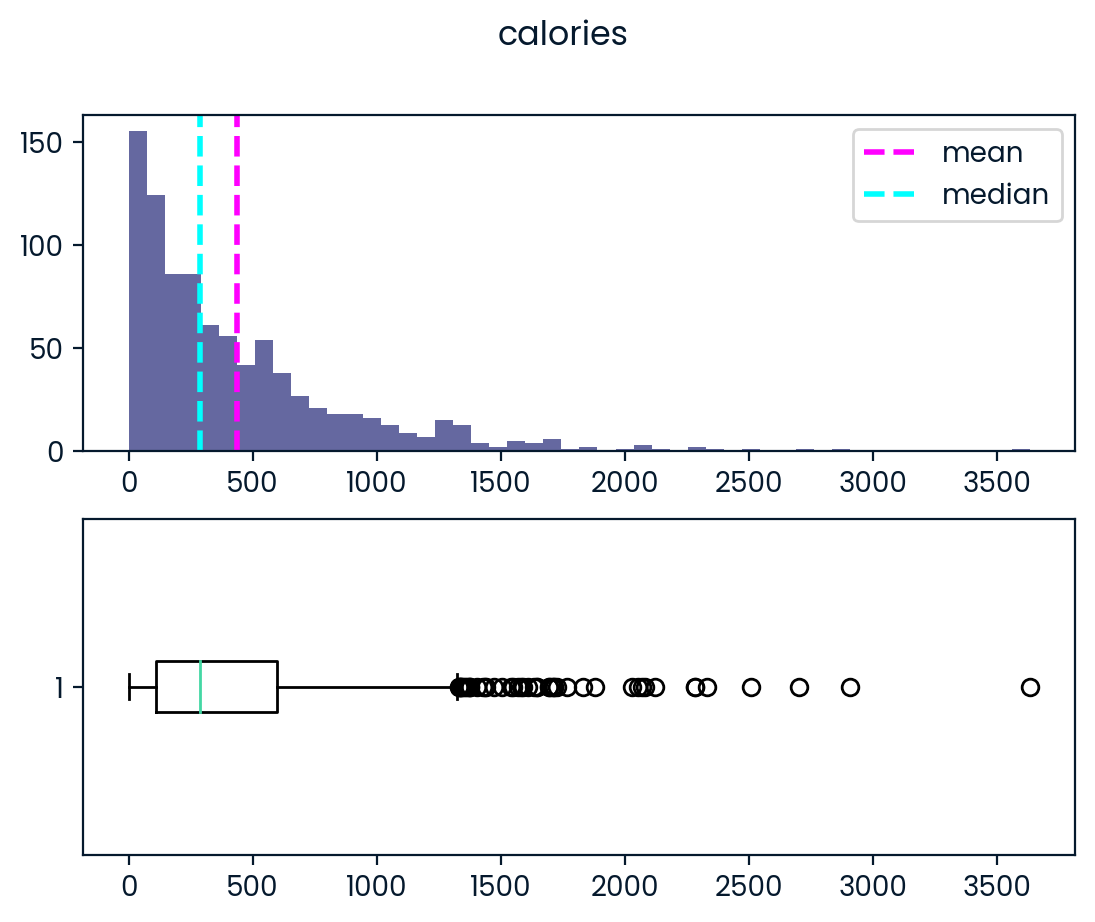

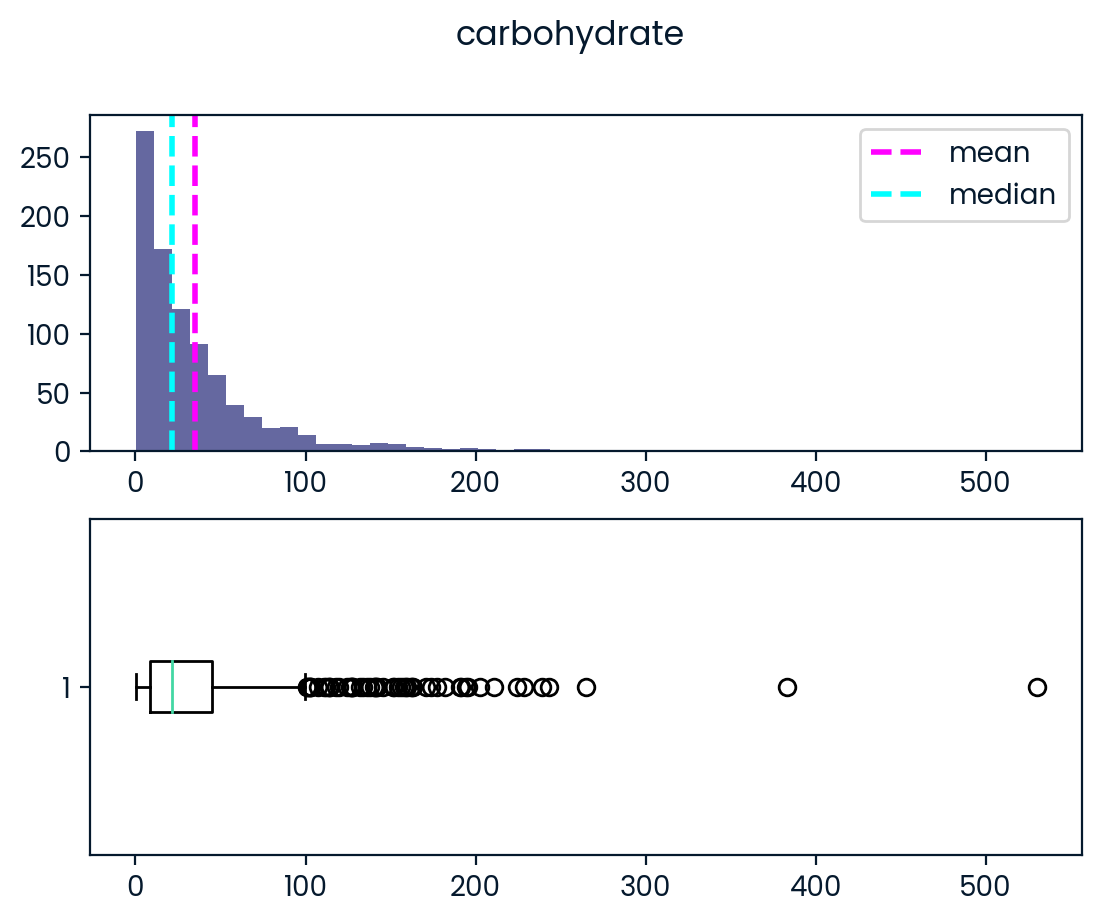

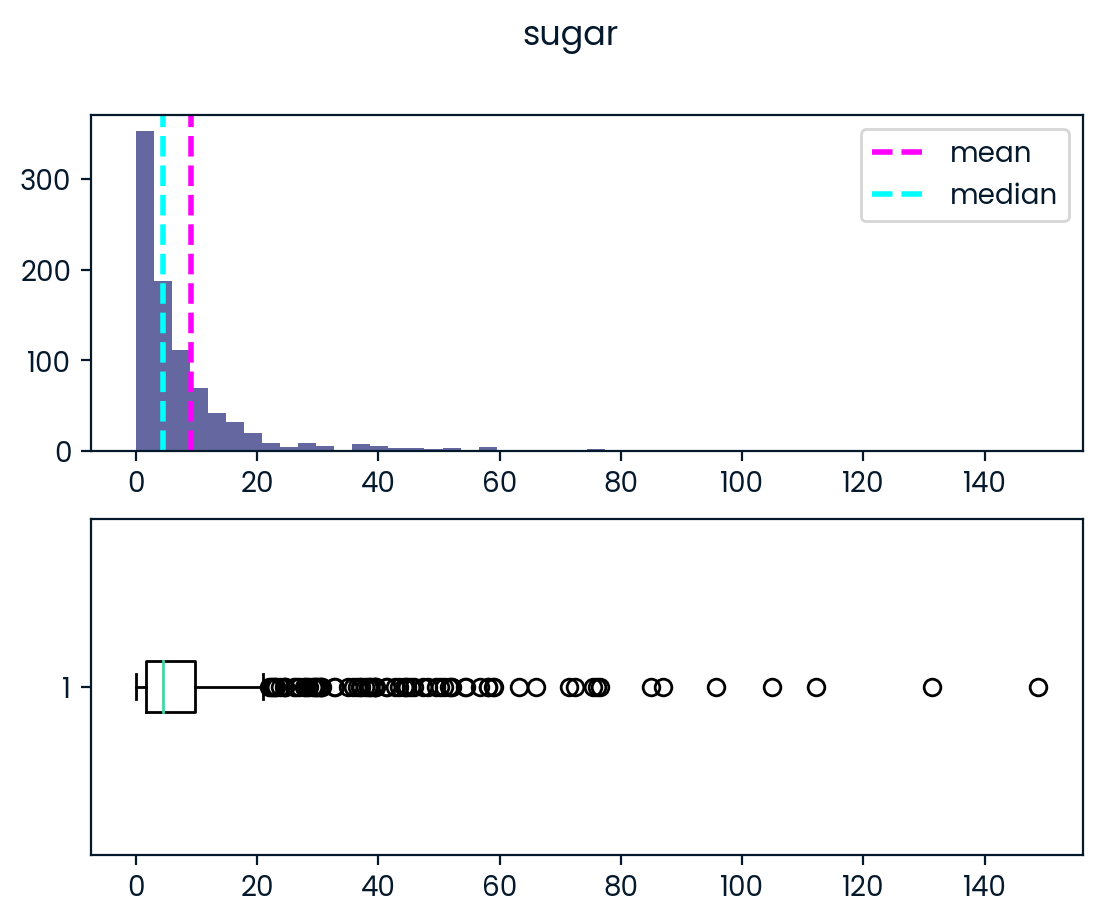

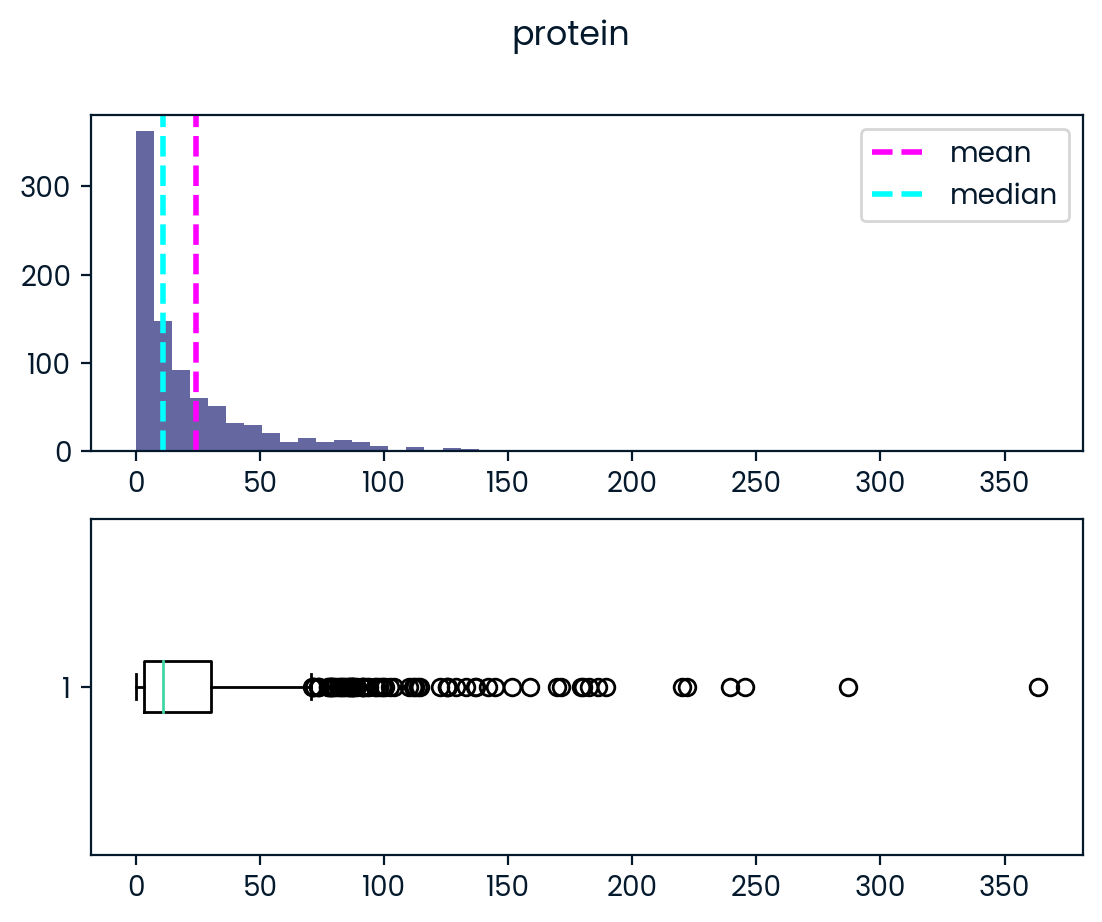

In [12]:
for col in numeric:
    fig, ax = plt.subplots(2, 1)
    ax[0].hist(data[col], bins=50)
    ax[0].axvline(data[col].mean(), color='magenta', linestyle='dashed', linewidth=2, label = 'mean')
    ax[0].axvline(data[col].median(), color='cyan', linestyle='dashed', linewidth=2, label ='median')
    
    ax[1].boxplot(data[col].dropna(), vert = False)
    ax[0].legend()
    fig.suptitle(col)
    plt.show()

The outliers were identified using **Modified Z-score method**, which doesn't require normal distribution of the data. Modified Z-score was calculated by category to better reflect the nuances. 

It is extremely unlikely that one serving of chicken meal has more than 3600 calories, when mean is 550 and median 379. On the other hand there are many unusual recipies and I didn't want to remove them from our data set. This is why, modified threshold was used to indicate, which data points should be treated as outliers. Usual threshold for Modified Z-Score is 3.5 but I decided to use higher - 4.5. 

Identified extreme values where replaced with their category median, which is more robust for outliers than mean.

In [13]:
def modified_z_score(x):
   """calculates and returns modified z-score"""
   x_median = x.median()
   mad = abs(x - x_median).median()
   mz = 0.6745 * (x - x_median) / mad
   return mz

for col in numeric:
    new_col = str('z_' + col)
    data[new_col] = data.groupby('category')[col].apply(lambda x: modified_z_score(x))

In [14]:
for col in numeric:
    score = str('z_' + col)
    data.loc[data[score]>4.5, col] = data[col].median()

As we can see below, after removing the most extreme values scale of the histograms and boxplots is much smaller. There are still many outliers left, but most probably they are just unusual recipes, so they will be kept for further analysis. For each column we also calculate coefficient of skewness, which confirms high skewness off data. 

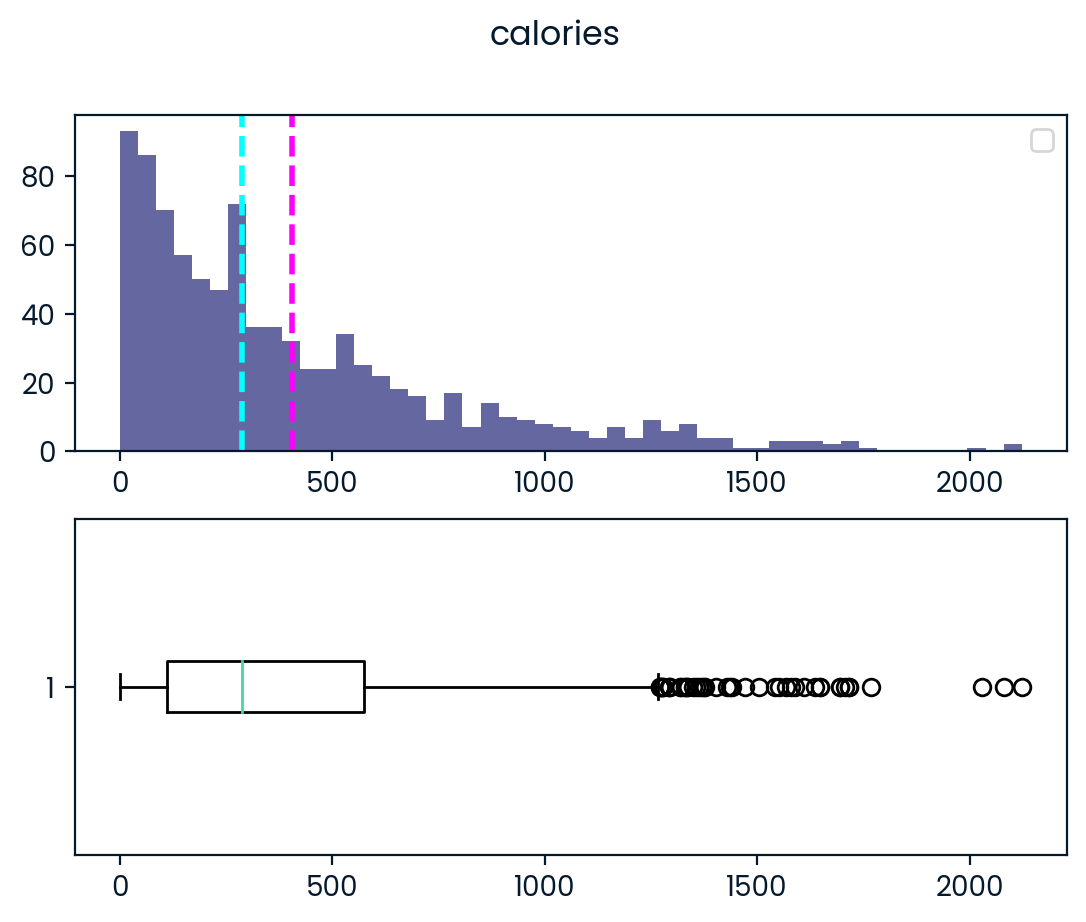

Fisher-Pearson coefficient of skewness for calories column is 1.4696374277671214


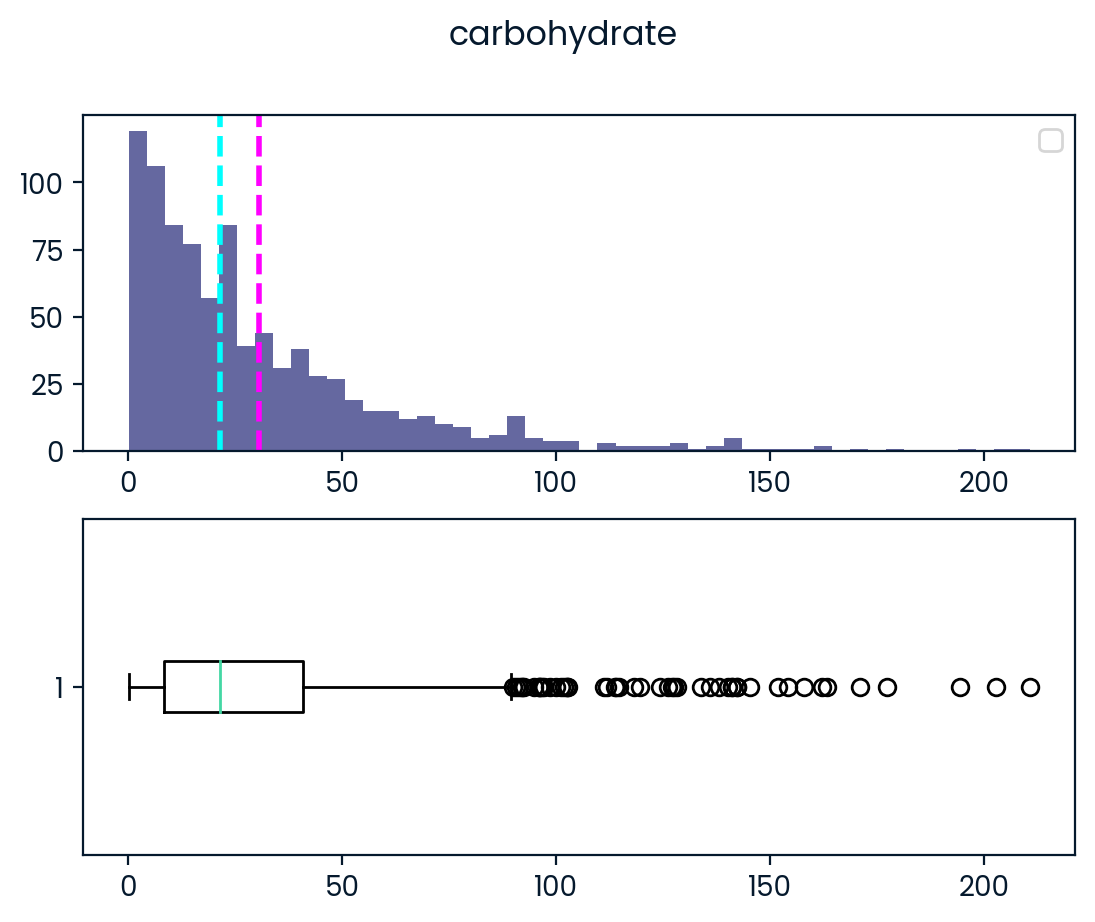

Fisher-Pearson coefficient of skewness for carbohydrate column is 2.0769080794363886


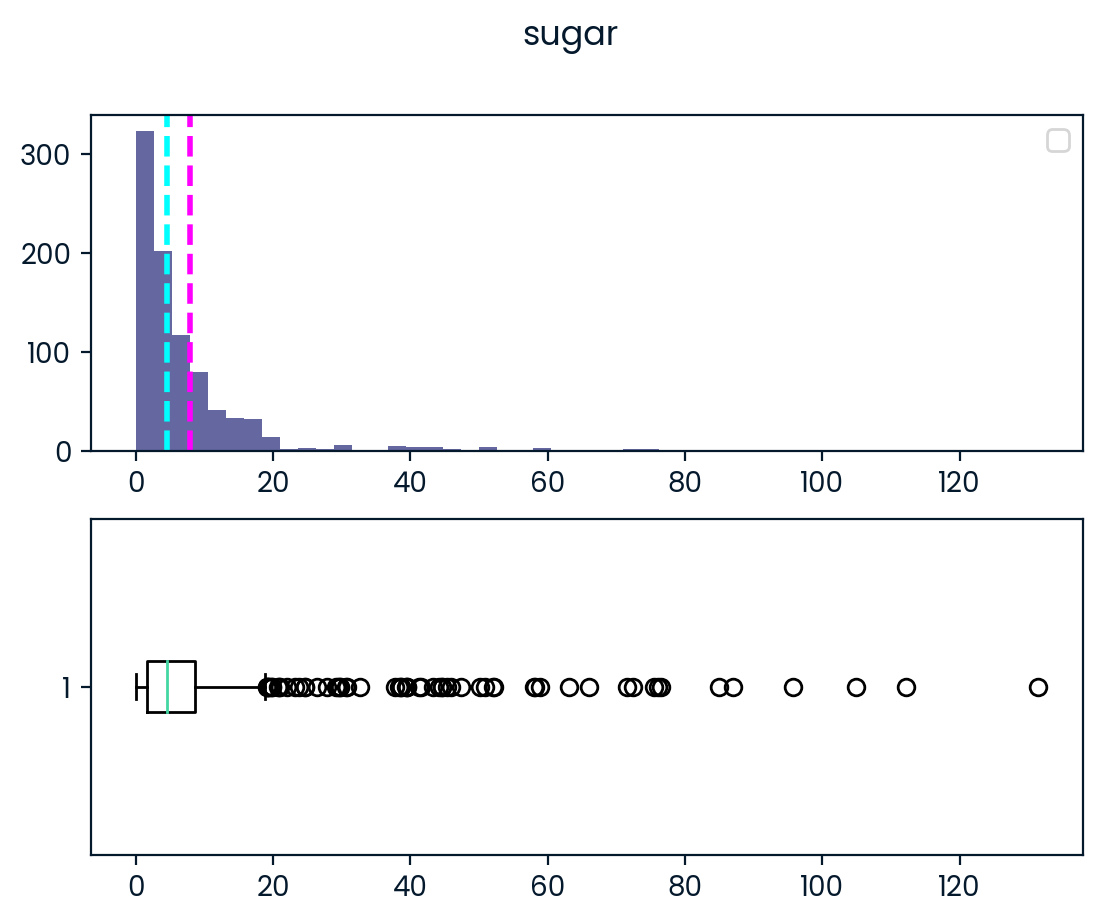

Fisher-Pearson coefficient of skewness for sugar column is 4.638324625239967


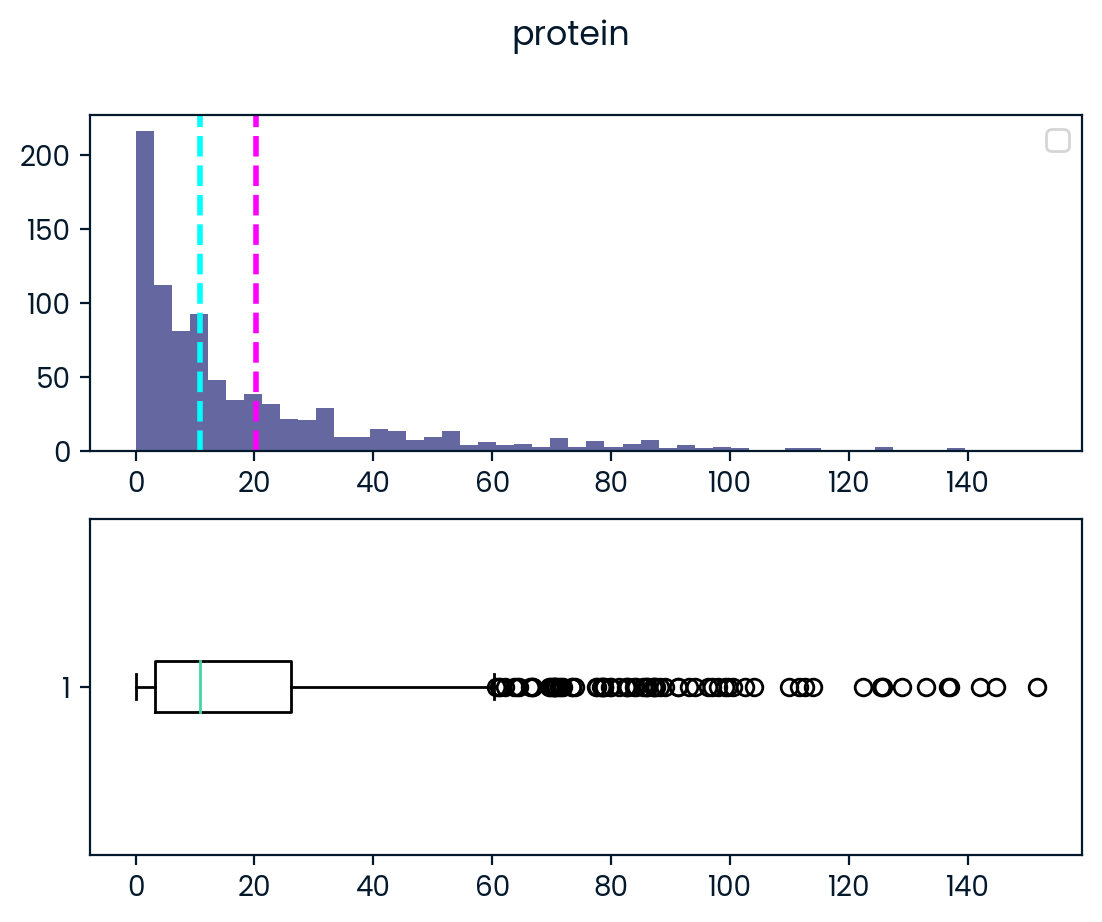

Fisher-Pearson coefficient of skewness for protein column is 2.1478663375037557


In [15]:
for col in numeric:
    fig, ax = plt.subplots(2, 1)
    ax[0].hist(data[col], bins=50)
    ax[0].axvline(data[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0].axvline(data[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    ax[0].legend()
    
    ax[1].boxplot(data[col].dropna(), vert = False)
    fig.suptitle(col)
    plt.show()
    print(f'Fisher-Pearson coefficient of skewness for {col} column is {data[col].skew()}')

From a heatmap, we can see that there is no strong correlation between numeric fetaures. Weak positive correalation can be observed between calories and carbohydrates, and weak negative correlation between proteins and carbohydrates. 

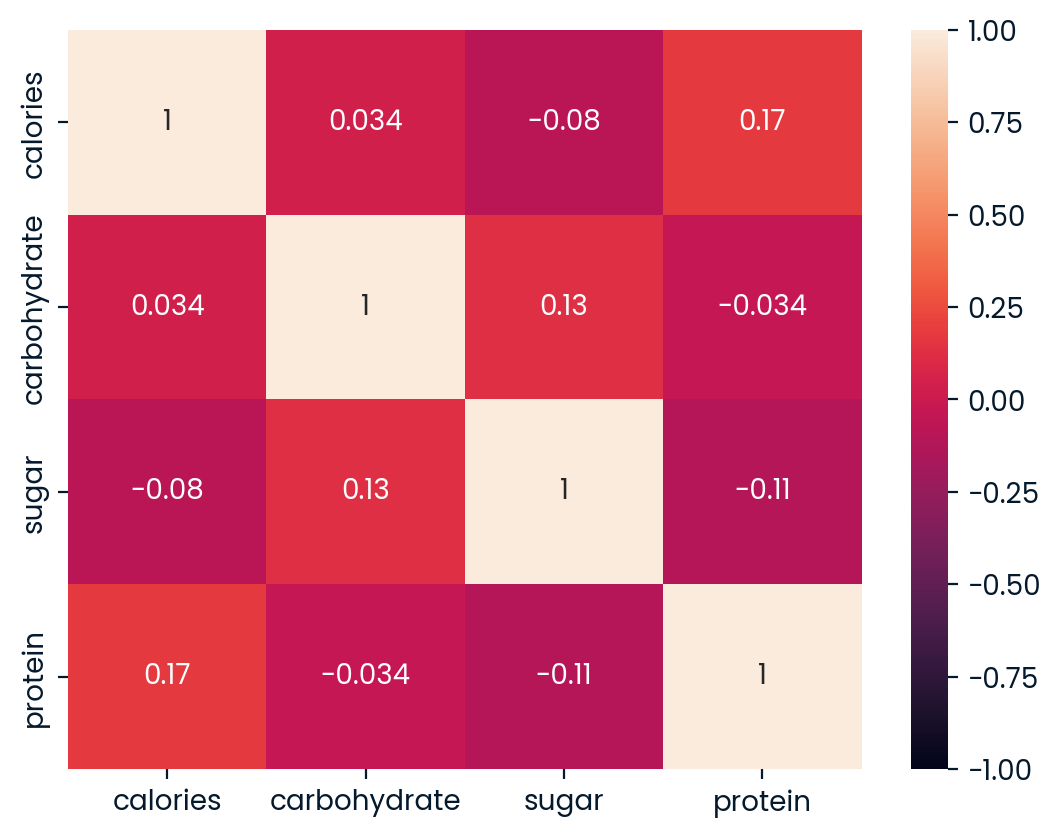

In [16]:
correlation = data[numeric].corr()
sns.heatmap(correlation, annot = True, vmin = -1, vmax = 1)
plt.show()

Let's now explore categorical variables. Numeric column 'servings' was treated as one of them, because there are only 4 possible values in it. As we can see, the most common category is 'Chicken' and most frequent number of servings is 4. In general, more that a half of recipes generate high traffic. 

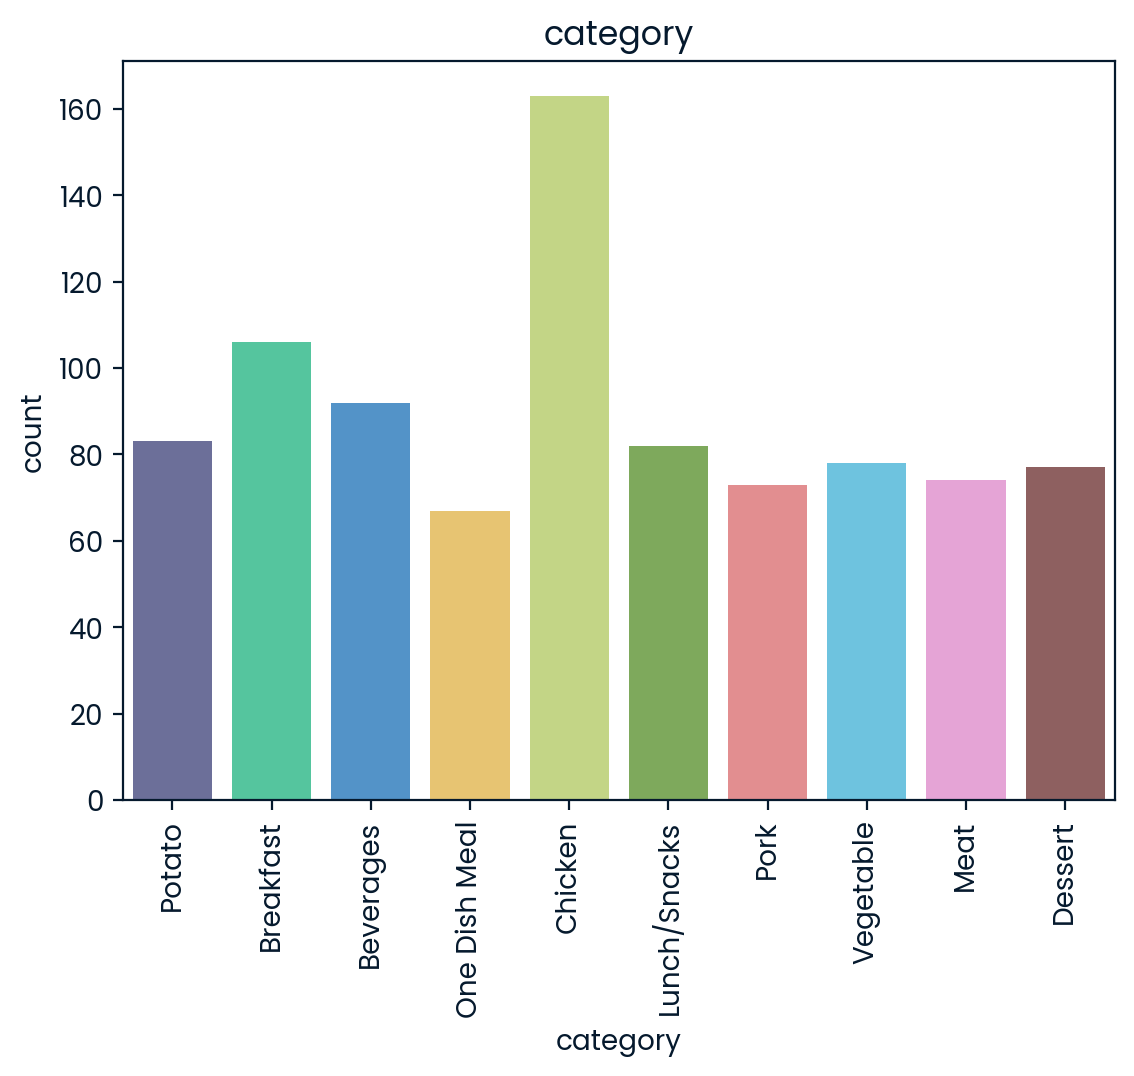

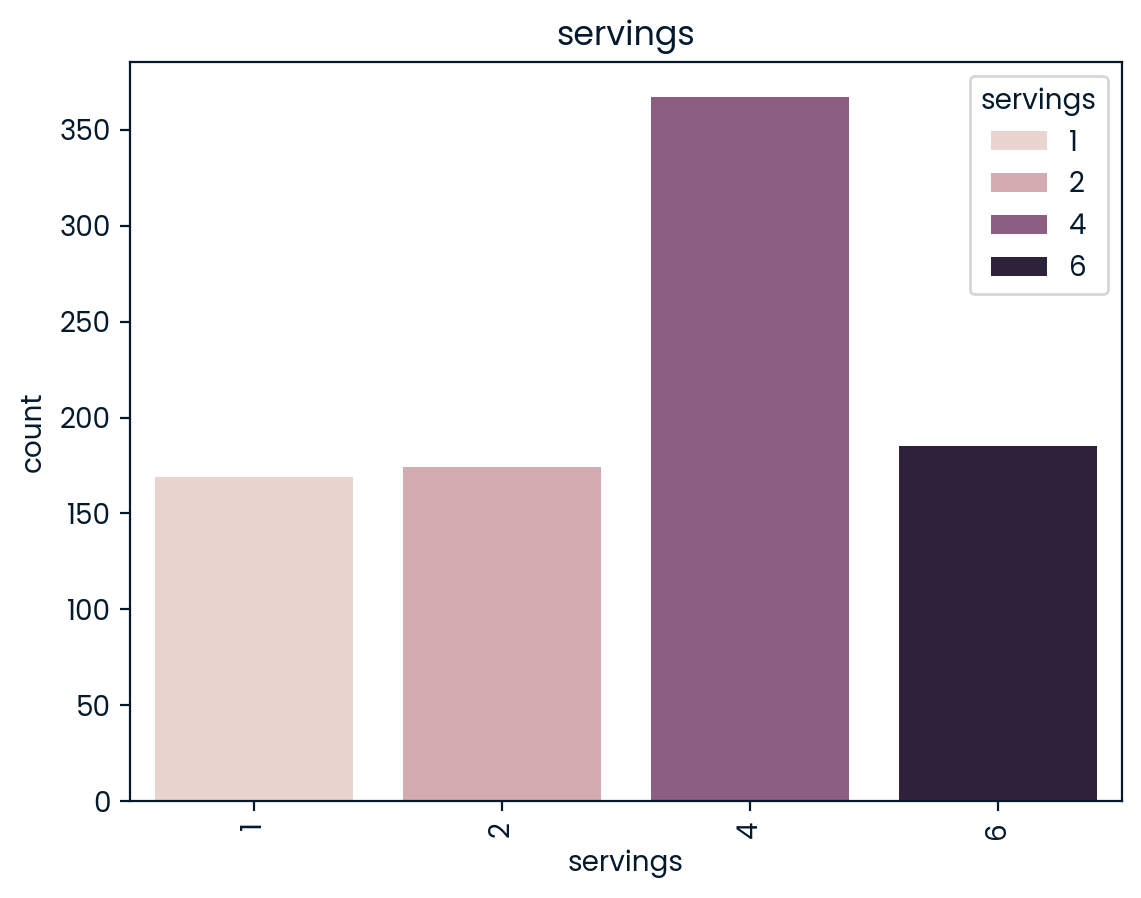

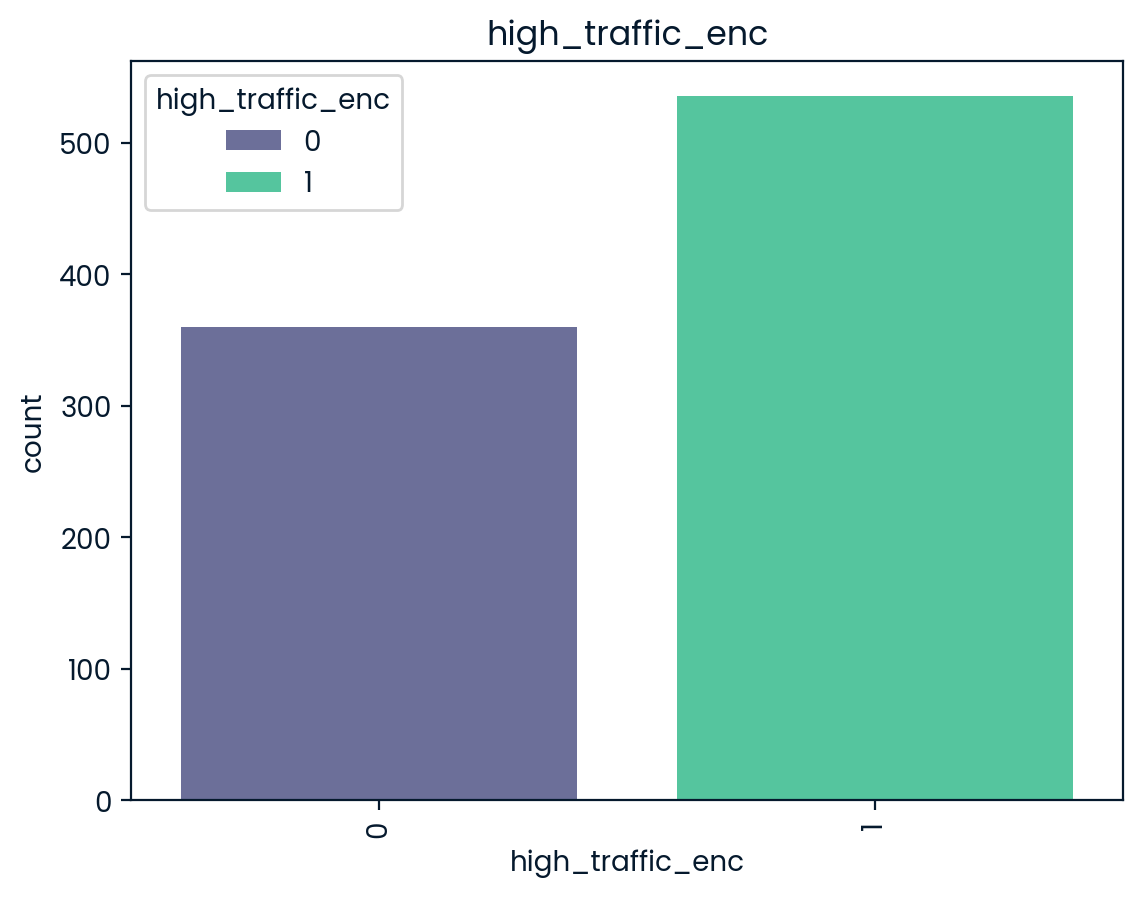

In [17]:
categorical = ['category', 'servings', 'high_traffic_enc']
for col in categorical:
    sns.countplot(x = col, data = data, hue = col)
    plt.xticks(rotation= 90)
    plt.title(col)
    plt.show()

Now it's time to explore our data with regards to target varable. 

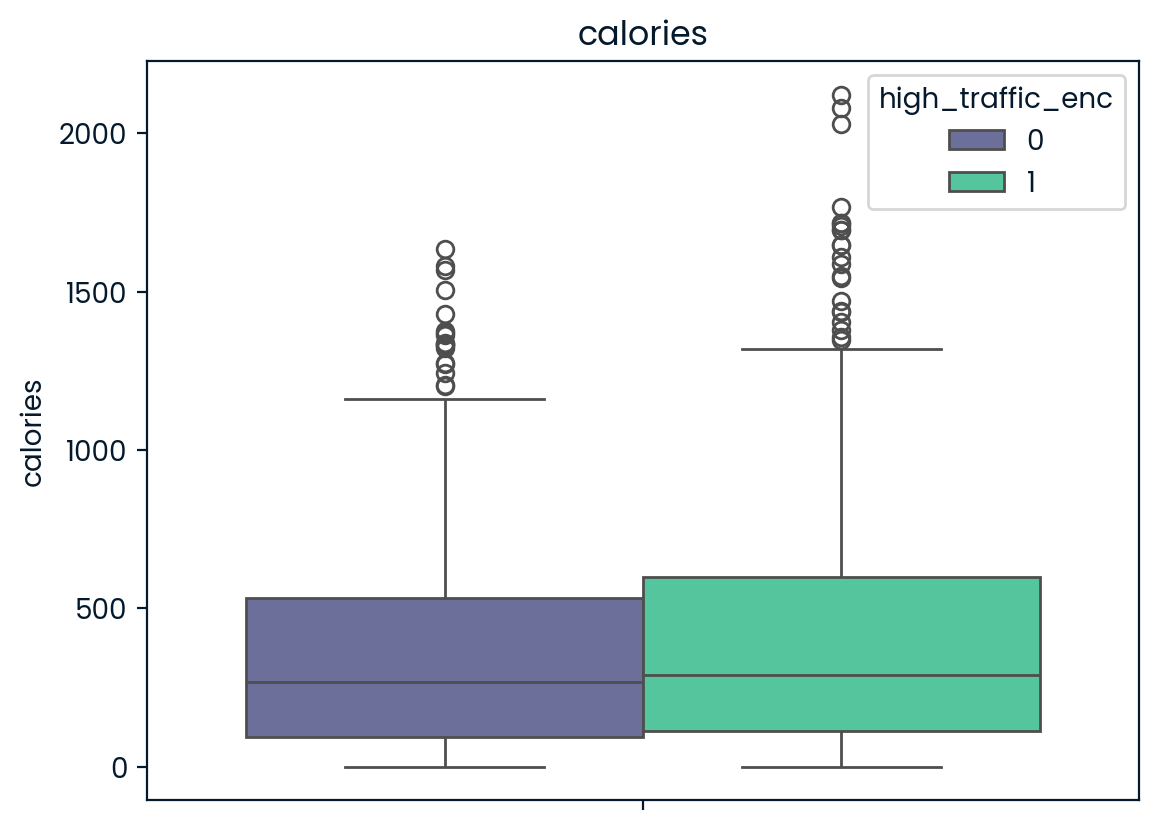

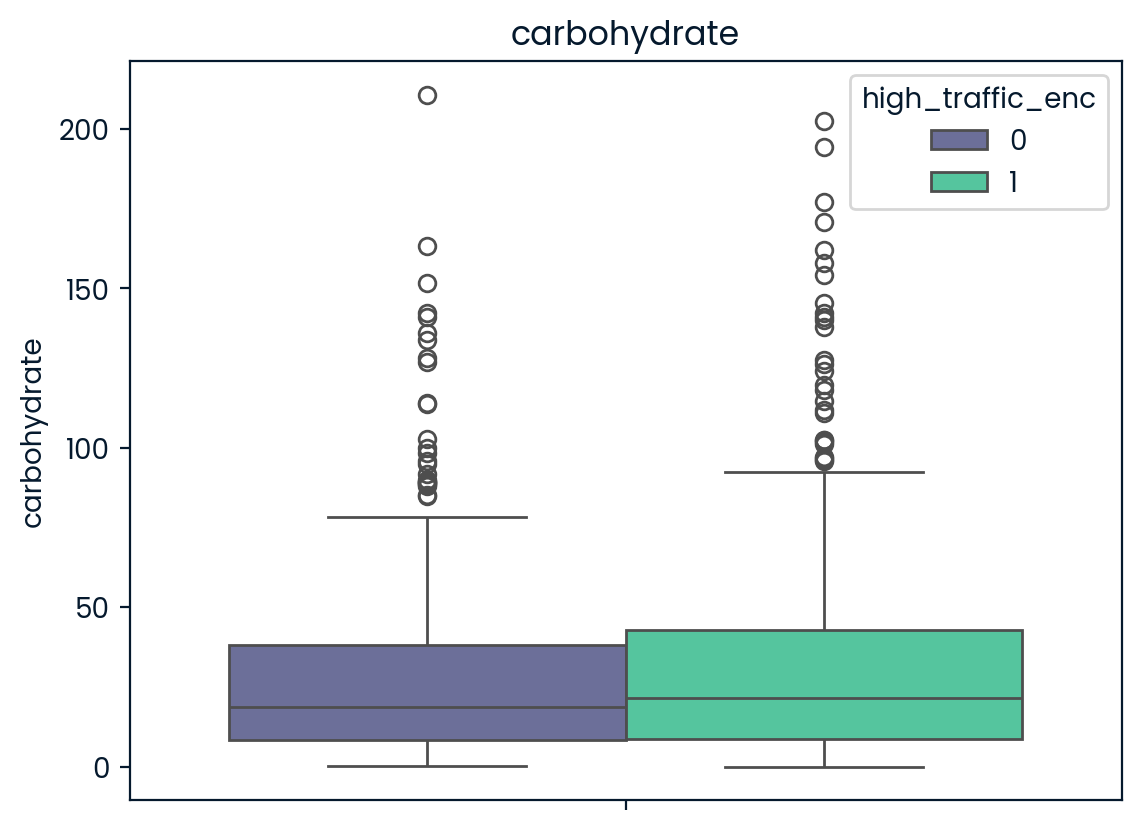

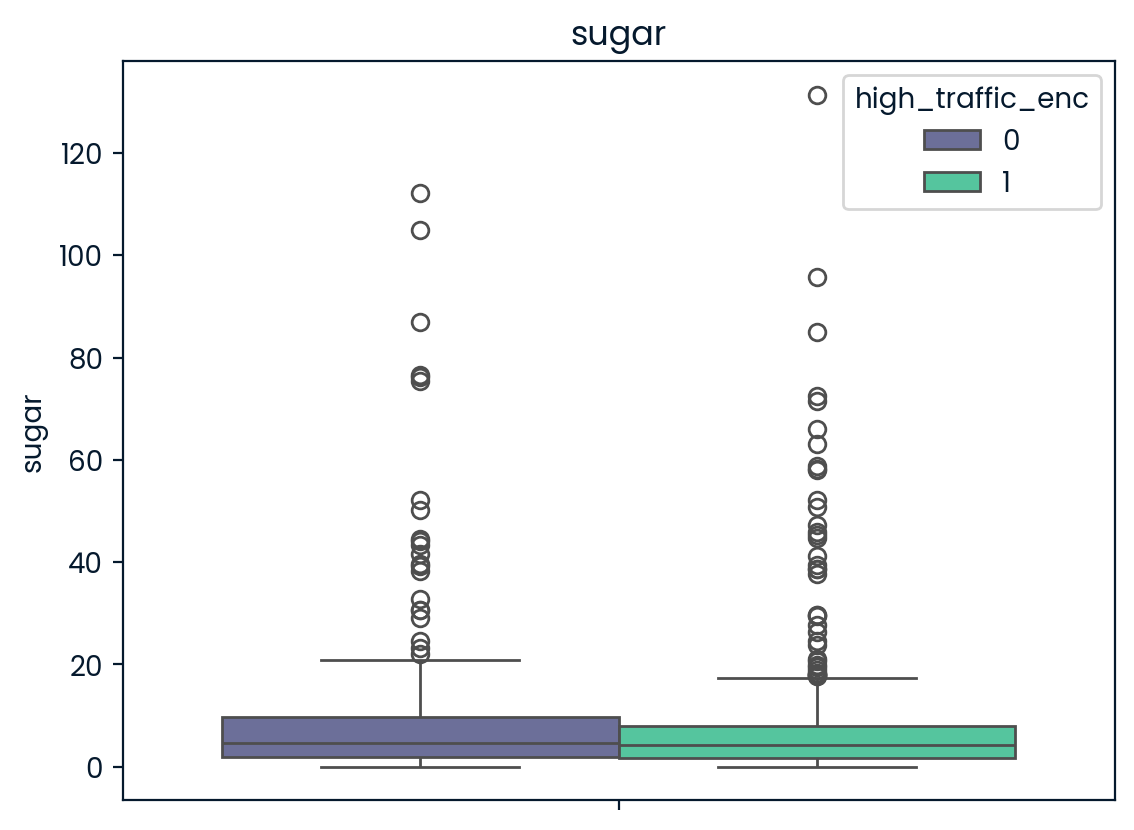

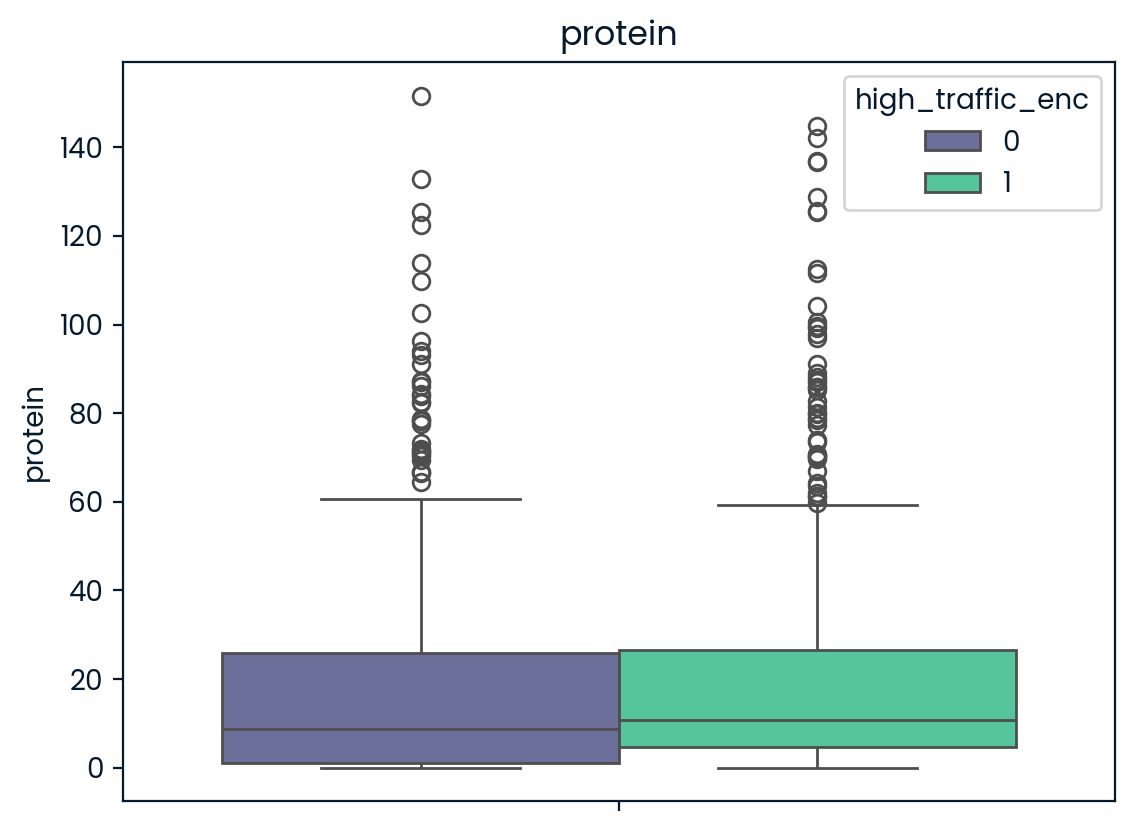

In [18]:
for col in numeric:
    sns.boxplot(y = col, hue = 'high_traffic_enc', data = data)
    plt.title(col)
    plt.show()

Below visualisations show that potato, pork and vegetable categories in almost every case generated high traffic while beverages and breakfasts didn't create much user engagement. More popular are recipes with larger number of servings - 4 and 6. 

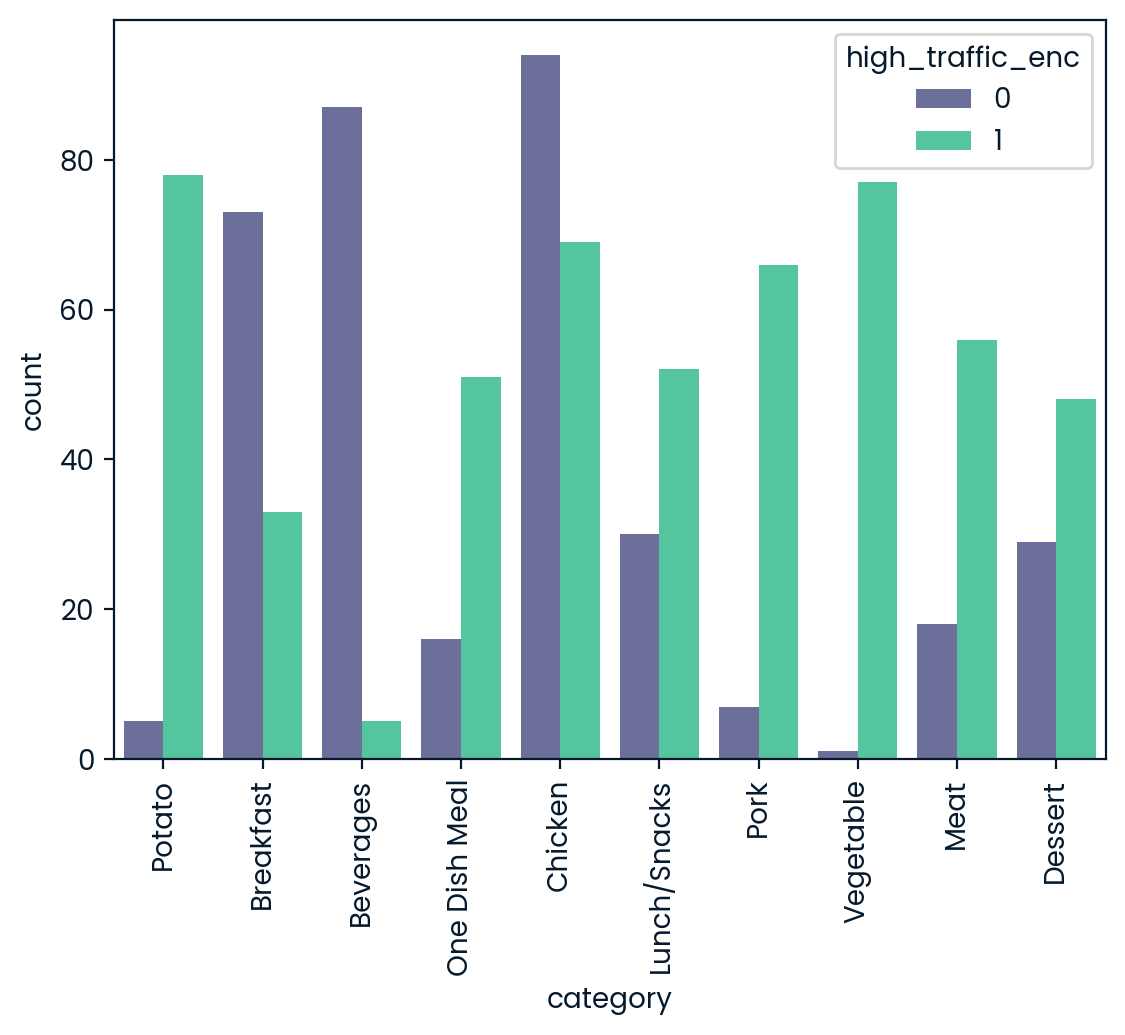

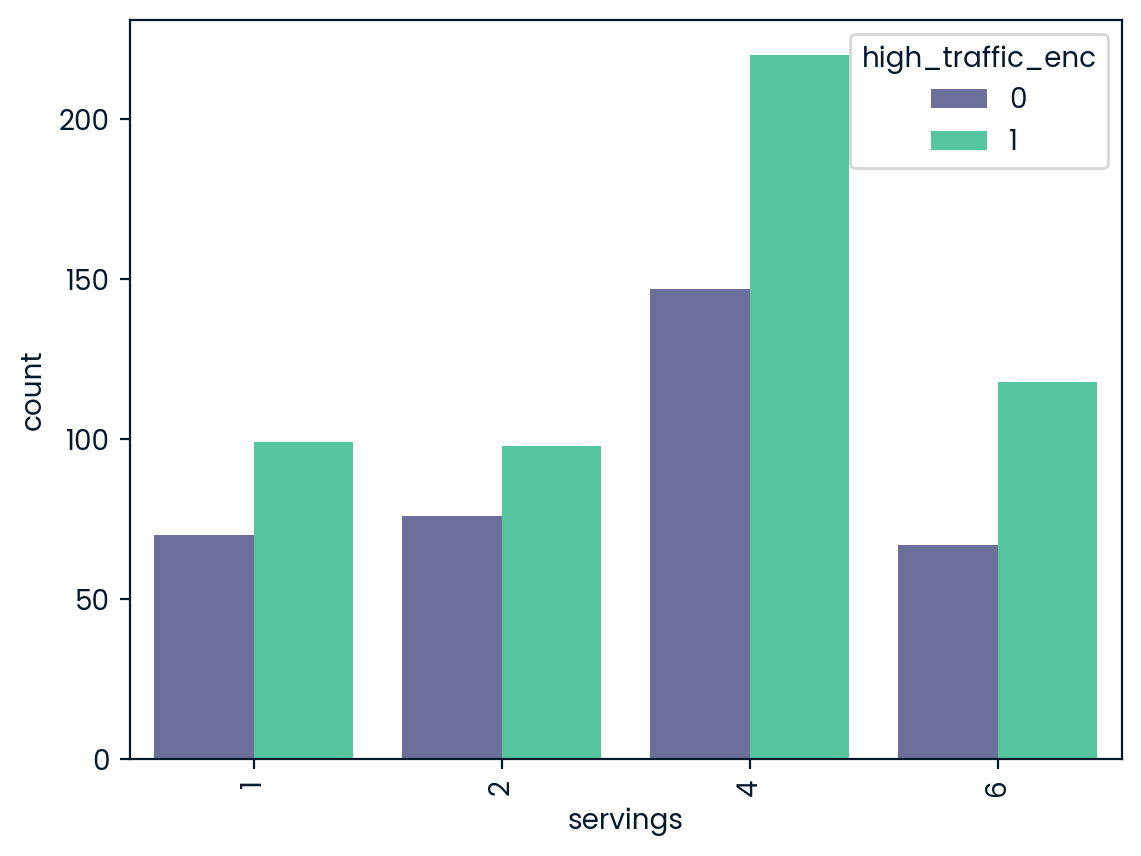

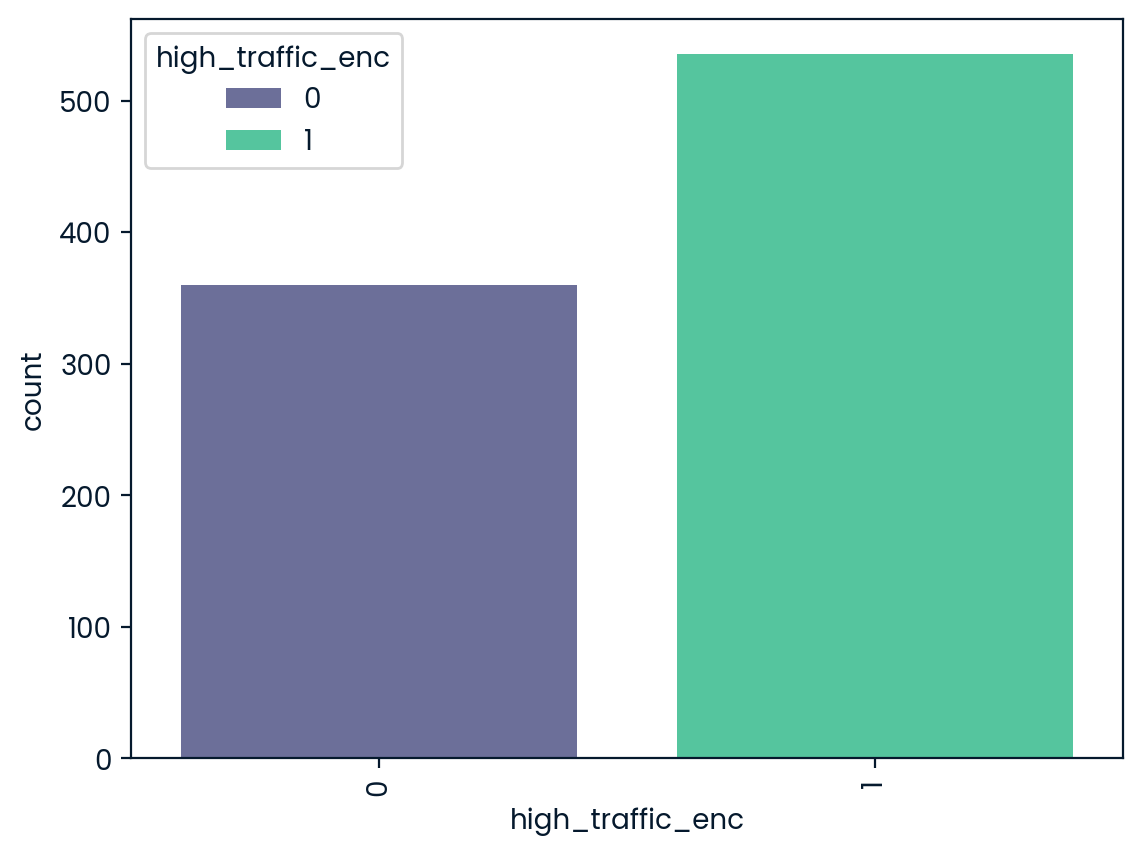

In [19]:
for col in categorical:
    sns.countplot(x = col, data = data, hue = 'high_traffic_enc')
    plt.xticks(rotation= 90)
    plt.show()

It also seems that a little more popular are recipes with higher number of calories, with more protein and carbohydrates, but smaller amount of sugar. This dependencey isn't that clear, ant without further analysis, it's hard to tell if this findings are statistically significant.

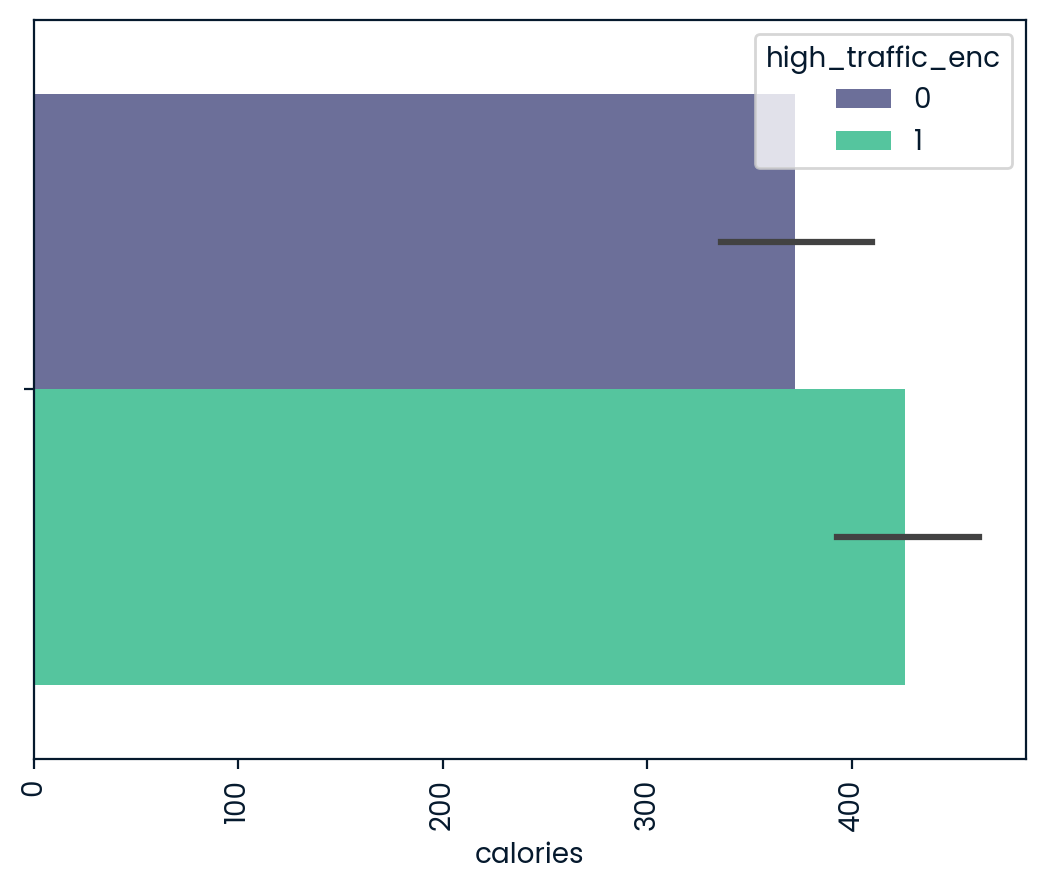

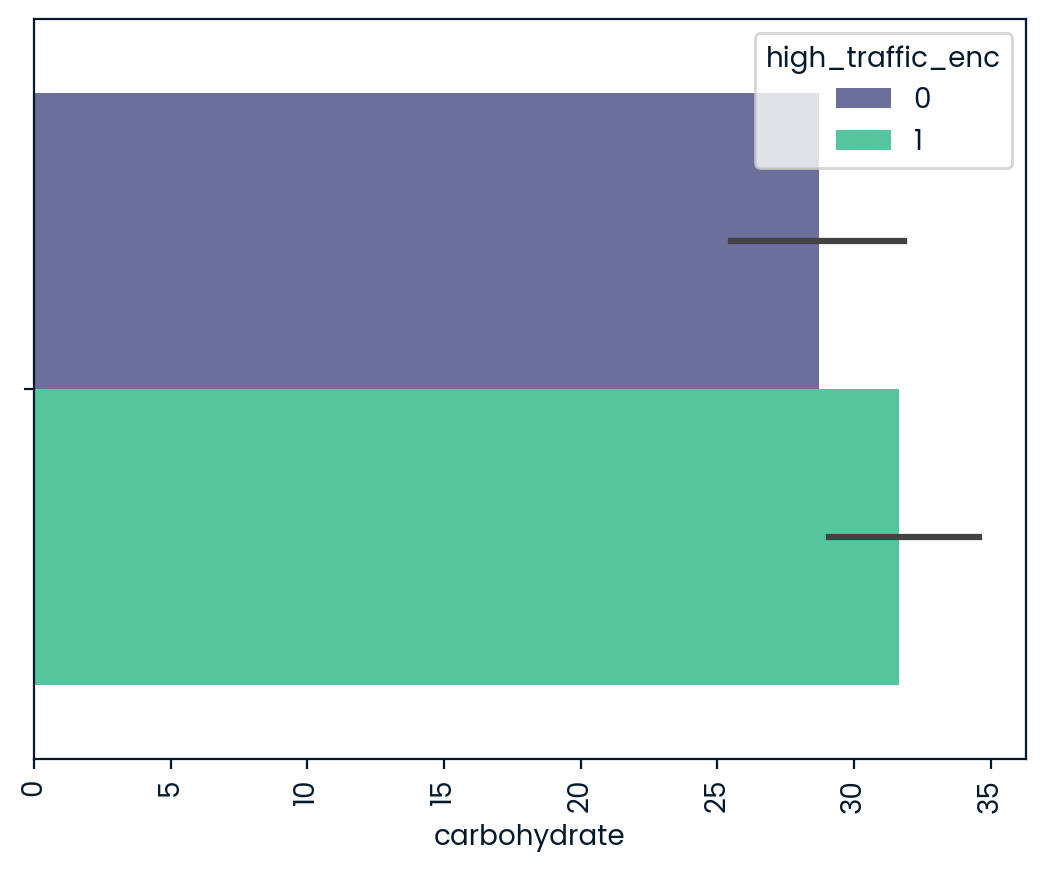

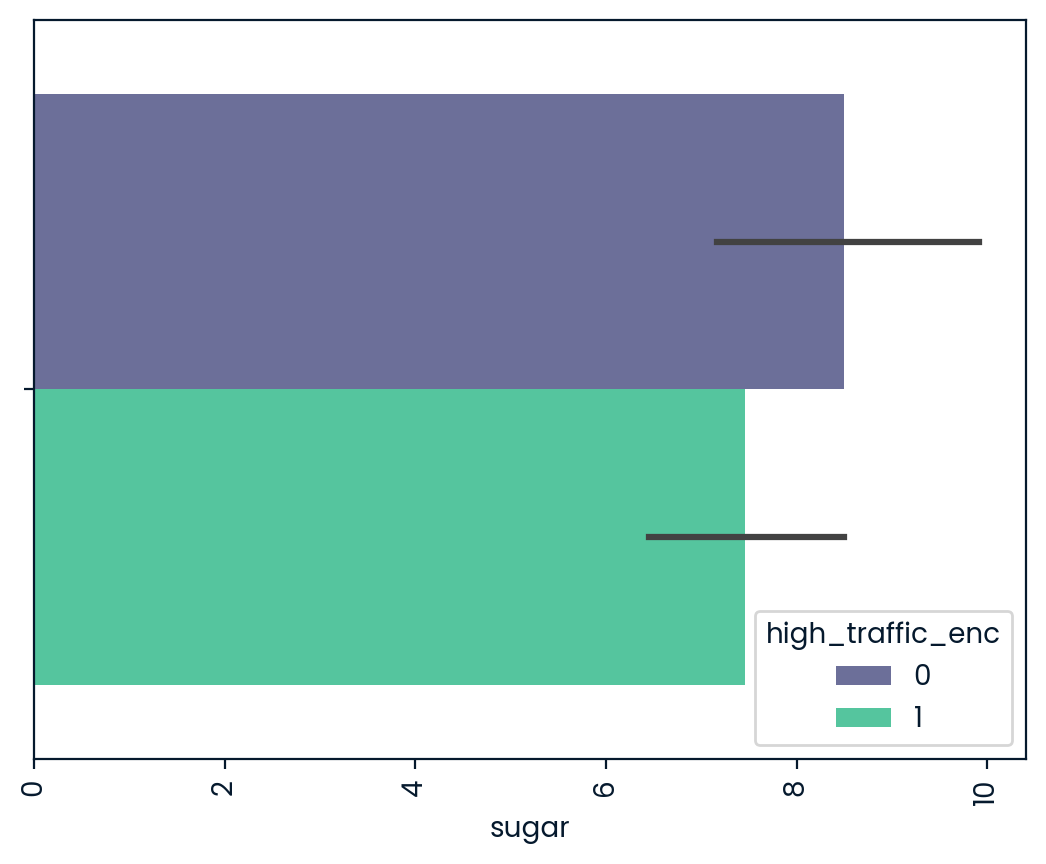

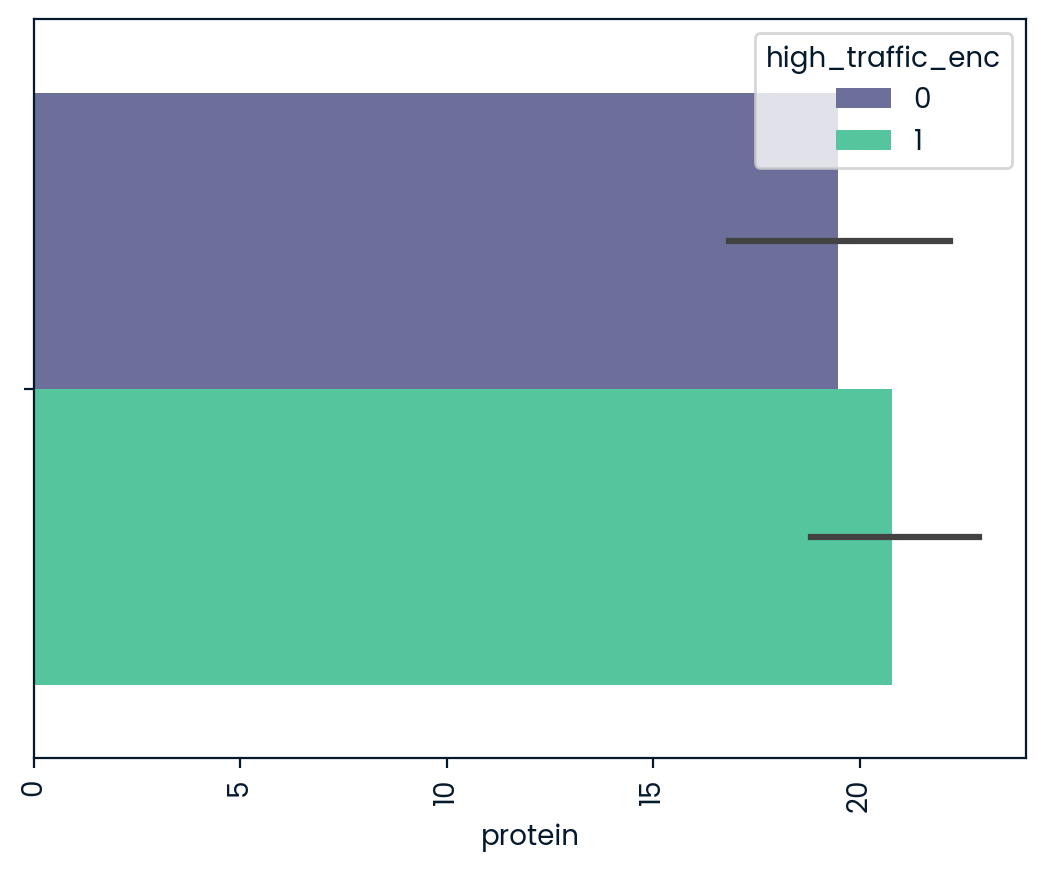

In [20]:
for col in numeric:
    sns.barplot(x = col, data = data, hue = 'high_traffic_enc')
    plt.xticks(rotation= 90)
    plt.show()

# Defining KPI
With business goal to identify popular recipes 80% of the time,there are several potential KPIs to choose from:

- Recall: How often a model correctly identifies popular recipes
- Precision: How many of recipes identified as populat were actually popular.
- F1-score: A balanced measure between Recall and Precision.
- Accuracy: How many of the total predictions were correct.

At the first glance, recall seems to be the best evaluation metric, as it helps to catch all recipes generating high traffic. In our case the the positive instances of target class constitute approximately 60% of all observations. Recall might be misleading, because high score is possible even with high number of false positives.

For this reason I decided to use 3 different KPI metrics to fully capture all the nuances of the models' predictions. Recall will ensure that we find as many popular recipes as possible, while precision will ensure quality of predictions to avoid false recommendations. F1-score consolidates both information into a single, more interpretable metric.

# Preparing data for modeling
Response variable has 2 possible outcome, so we deal with binary classification. I choose two types of models fot this problem: logistic regression and random forest classifier. 

There are still few issuess that need to be addressed:

- categorical values - they will be encoded with get_dummies method
- unnecessary columns - for modelling we do not need 'recipe' column with ids nor calculated Z-scores. All of them will be dropped
- data needs to be split to train and testing sets

Logistic regression required also addressing additional problems:

- different scales of numeric data - numeric values will be normalised with StandardScaler
- skewness of data - numeric data will be transformed with Box-Cox method, which requires positive, non-zero values. There are two values equal to 0 in 'protein' column, which need to be replaced with very small positive numbers. 

Last two steps will be performed after splitting data to train/test set to avoid data leakage only on data used to train Logistic Regression




In [21]:
# assigning response variable to y and dropping unnecessary columns
y = data['high_traffic_enc'].values
features = data.drop(['recipe', 'high_traffic_enc', 'z_calories', 'z_sugar', 'z_carbohydrate', 'z_protein'], axis =1)

In [22]:
features = pd.get_dummies(data=features, columns=['category', 'servings'])
features.loc[features['protein']==0, 'protein'] = 0.00001
#train test split for logistic regression
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, stratify = y, random_state = 52 )

As we can see in KDE plots below, after transformation skewness of all numeric columns is close to zero and they are much closer to normal distribution.

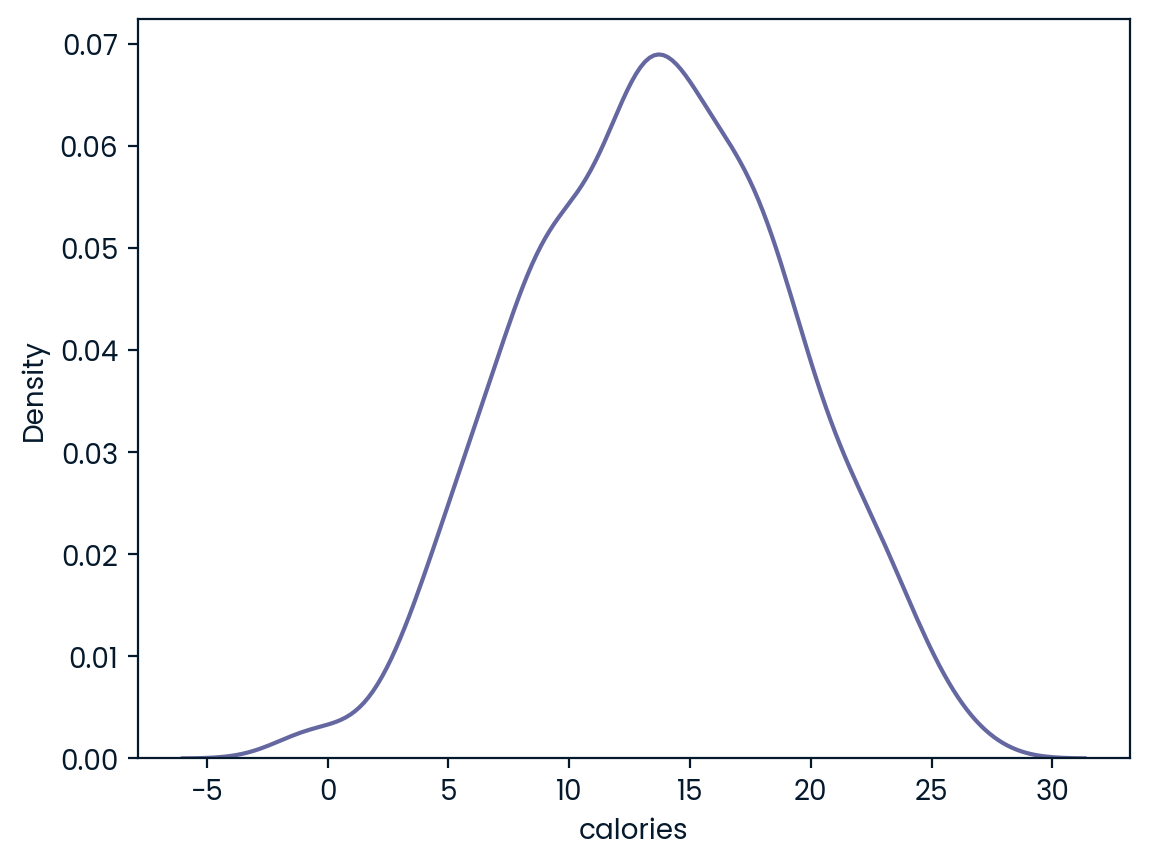

Fisher-Pearson coefficient of skewness for calories column is -0.05361505536751048


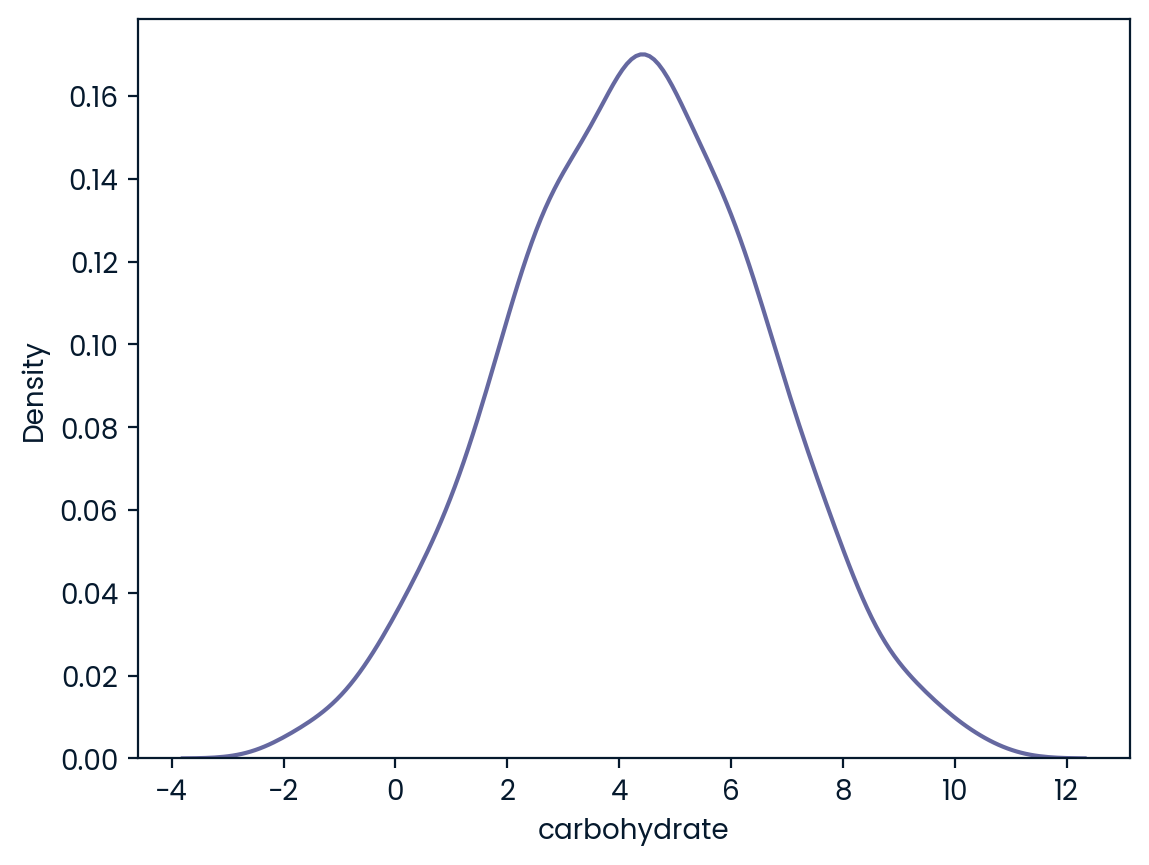

Fisher-Pearson coefficient of skewness for carbohydrate column is -0.026303692657888397


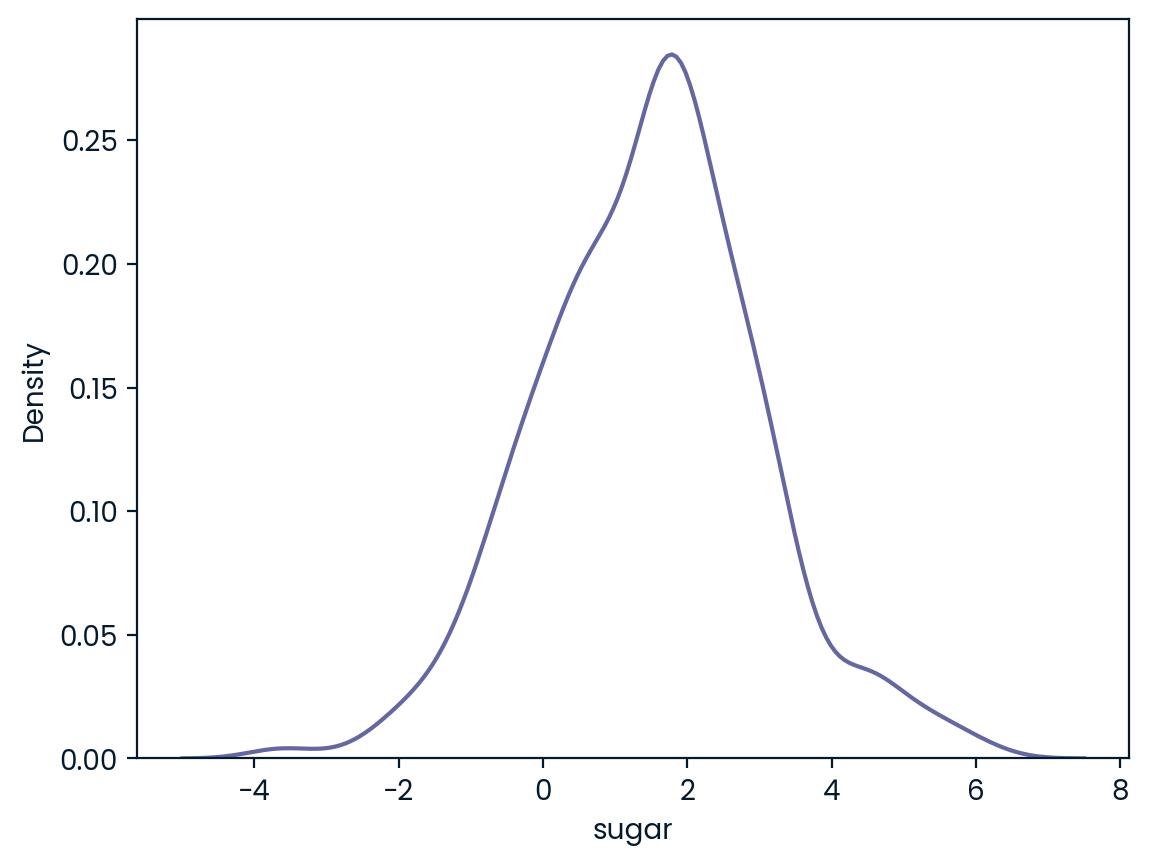

Fisher-Pearson coefficient of skewness for sugar column is 0.0212055101486018


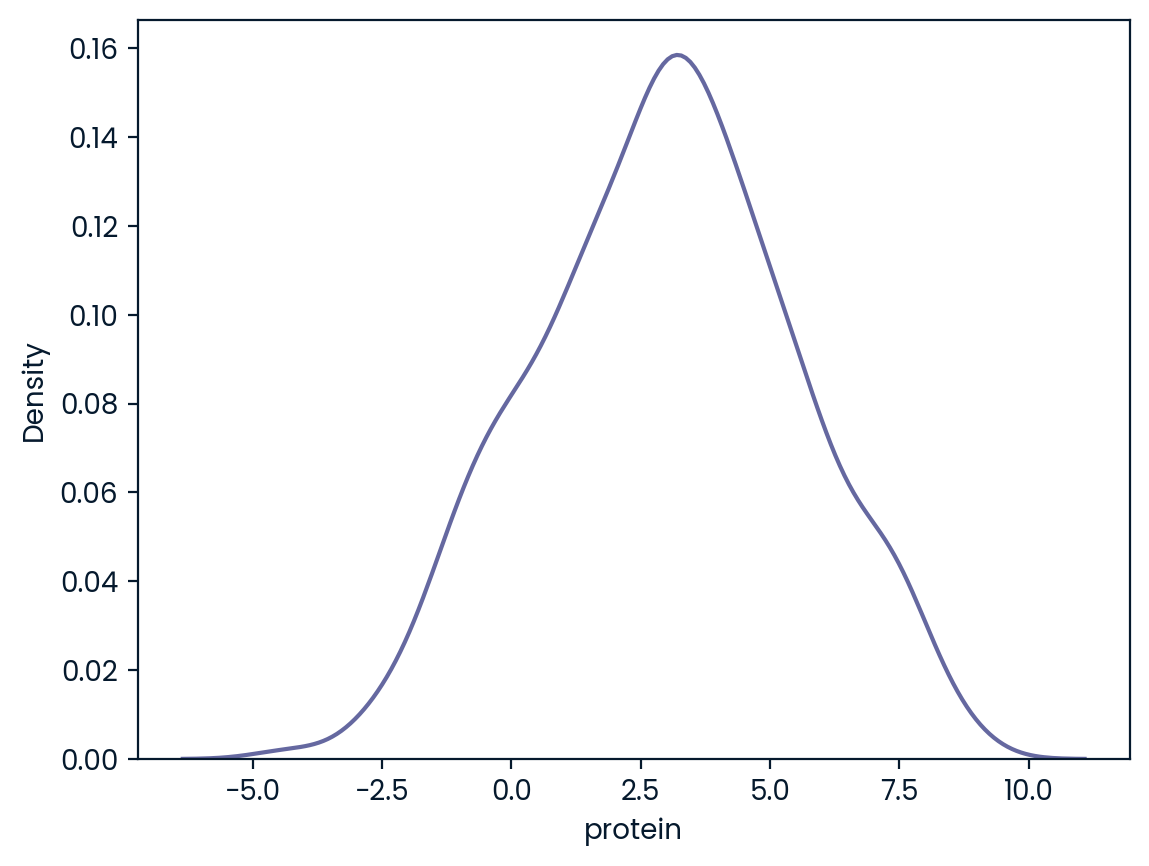

Fisher-Pearson coefficient of skewness for protein column is -0.0627974737305241


In [23]:

for col in numeric:
    X_train[col] = boxcox(X_train[col])[0]
    sns.kdeplot(x=col, data = X_train)
    plt.show()
    print(f'Fisher-Pearson coefficient of skewness for {col} column is {X_train[col].skew()}')
    
for col in numeric:
    X_test[col] = boxcox(X_test[col])[0]

In [24]:
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])


In [25]:
X_train = X_train.values
X_test = X_test.values

# Training first model

The simplest model we can use for binary classification is **Logistic Regression**, so let's train it as our baseline model. I used GridSearchCV to find best regularization hyperparameter C, but it turned out that default value of 1 performed best. 

After training final, hypertuned model we get precision of 0.80, recall of 0.81 and F-1 score 0.81 for test set. All metrics meet our 80% criteria.

In [85]:
#looking for best params for logistic regression
params_lg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lg = LogisticRegression(random_state=52)
grid_lg = GridSearchCV(lg, params_lg, scoring='precision', cv=5)
grid_lg.fit(X_train, y_train)
print("Best parameters for Logistic Regression found in GridSearchCV: ", grid_lg.best_params_)
print("Best accuracy score from GridSearchCV for Logistic Regression: ", grid_lg.best_score_)


Best parameters for Logistic Regression found in GridSearchCV:  {'C': 1}
Best accuracy score from GridSearchCV for Logistic Regression:  0.7867246604588589


In [87]:
#fiting model with best params
lg_grid = LogisticRegression(C=1, random_state=52)
lg_grid.fit(X_train, y_train)
y_pred_lg = lg_grid.predict(X_test)
acc_score_lg = lg_grid.score(X_test, y_test )
precision_lg = precision_score(y_test, y_pred_lg)
print(f'Logistic Regression precision score (test set): {precision_lg:.2f}')
lg_classification_raport = classification_report(y_test, y_pred_lg, target_names=['0', '1'], output_dict=True)


Logistic Regression accuracy score (test set): 0.77
Logistic Regression precision score (test set): 0.81


{'0': {'precision': 0.719626168224299,
  'recall': 0.7129629629629629,
  'f1-score': 0.7162790697674418,
  'support': 108},
 '1': {'precision': 0.808641975308642,
  'recall': 0.8136645962732919,
  'f1-score': 0.8111455108359134,
  'support': 161},
 'accuracy': 0.7732342007434945,
 'macro avg': {'precision': 0.7641340717664705,
  'recall': 0.7633137796181274,
  'f1-score': 0.7637122903016775,
  'support': 269},
 'weighted avg': {'precision': 0.7729032869625118,
  'recall': 0.7732342007434945,
  'f1-score': 0.7730578690686459,
  'support': 269}}

# Second model
The second model trained was Random Forrest Classifier. Its huge advantage is fact, that it requires less data prepocessing than Logistc Regression. Again, I used GridSearchCV to find best hyperparameters and trained model using them. 

This time recall score is high - 0.83, what meets our 80% crietria. Overall performance is worse - 0.76 precision and 0.79 F-1 score is below expectations.

In [28]:
#preparing features and train/test split for Random Forrest
y_dtr = data['high_traffic_enc'].values
features_dtr = data.drop(['recipe', 'high_traffic_enc', 'z_calories', 'z_sugar', 'z_carbohydrate', 'z_protein'], axis =1)
features_dtr = pd.get_dummies(data=features_dtr, columns=['category']).values  
X_trd, X_ted, y_trd, y_ted = train_test_split(features_dtr, y_dtr, test_size=0.3, stratify = y, random_state = 52 )

In [88]:
#looking for best params for Random Forrest
rf = RandomForestClassifier(random_state = 52)
params_rf = {
    'max_depth': [10, 25, 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [10, 15, 20],
    'min_samples_split': [6, 8, 12],
    'n_estimators': [100, 200, 300]
}
grid_rf = GridSearchCV(rf, params_rf, scoring='precision', cv=5)
grid_rf.fit(X_trd, y_trd)
print("Best parameters for Random Forest Classifier: ", grid_rf.best_params_)
print("Best score for Random Forest Classifier: ", grid_rf.best_score_)

Best parameters for Random Forest Classifier:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 300}
Best score for Random Forest Classifier:  0.7502267783061409


In [90]:
#training model with best params
rf_grid = RandomForestClassifier(max_depth = 10, max_features= 'auto', min_samples_leaf= 10, min_samples_split= 6, n_estimators= 300, random_state = 52)
rf_grid.fit(X_trd, y_trd)
y_pred_rf = rf_grid.predict(X_ted)
acc_score_rf = rf_grid.score(X_ted, y_ted)
precision_rf = precision_score(y_ted, y_pred_rf)
print(f'Logistic Regression precision score (test set): {precision_rf:.2f}')
rf_classification_raport = classification_report(y_ted, y_pred_rf, target_names=['0', '1'], output_dict=True)
rf_classification_raport

Logistic Regression precision score (test set): 0.76


{'0': {'precision': 0.7096774193548387,
  'recall': 0.6111111111111112,
  'f1-score': 0.6567164179104478,
  'support': 108},
 '1': {'precision': 0.7613636363636364,
  'recall': 0.8322981366459627,
  'f1-score': 0.795252225519288,
  'support': 161},
 'accuracy': 0.7434944237918215,
 'macro avg': {'precision': 0.7355205278592376,
  'recall': 0.721704623878537,
  'f1-score': 0.7259843217148678,
  'support': 269},
 'weighted avg': {'precision': 0.7406122927318515,
  'recall': 0.7434944237918215,
  'f1-score': 0.7396319012748465,
  'support': 269}}

# Model comparison



Finally let's compare performance of our models to find the one best serving our needs.






In [73]:
comparison = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forrest Classifier'], 'Recall': [lg_classification_raport['1']['recall'], rf_classification_raport['1']['recall']], 'Precision':[precision_lg, precision_rf], 'F-1 score': [lg_classification_raport['1']['f1-score'], rf_classification_raport['1']['f1-score']]})
comparison


,Model,Recall,Precision,F-1 score
0,Logistic Regression,0.813665,0.808642,0.811146
1,Random Forrest Classifier,0.832298,0.761364,0.795252


When we take into consideration all three KPI metrics, Logistic Regression model performs better than Random Forrest Classifier. It has stable scores across all defined KPIs and all of them are meeting business criteria of 80%. Random Forrest Classifier has better Recall score (0.83), however Precision and F-1 score are below expectations.

For full comparison of models I calculated ROC AUC, which shows that Logistic Regression is also better at distinguishing between positive and negative classes. 

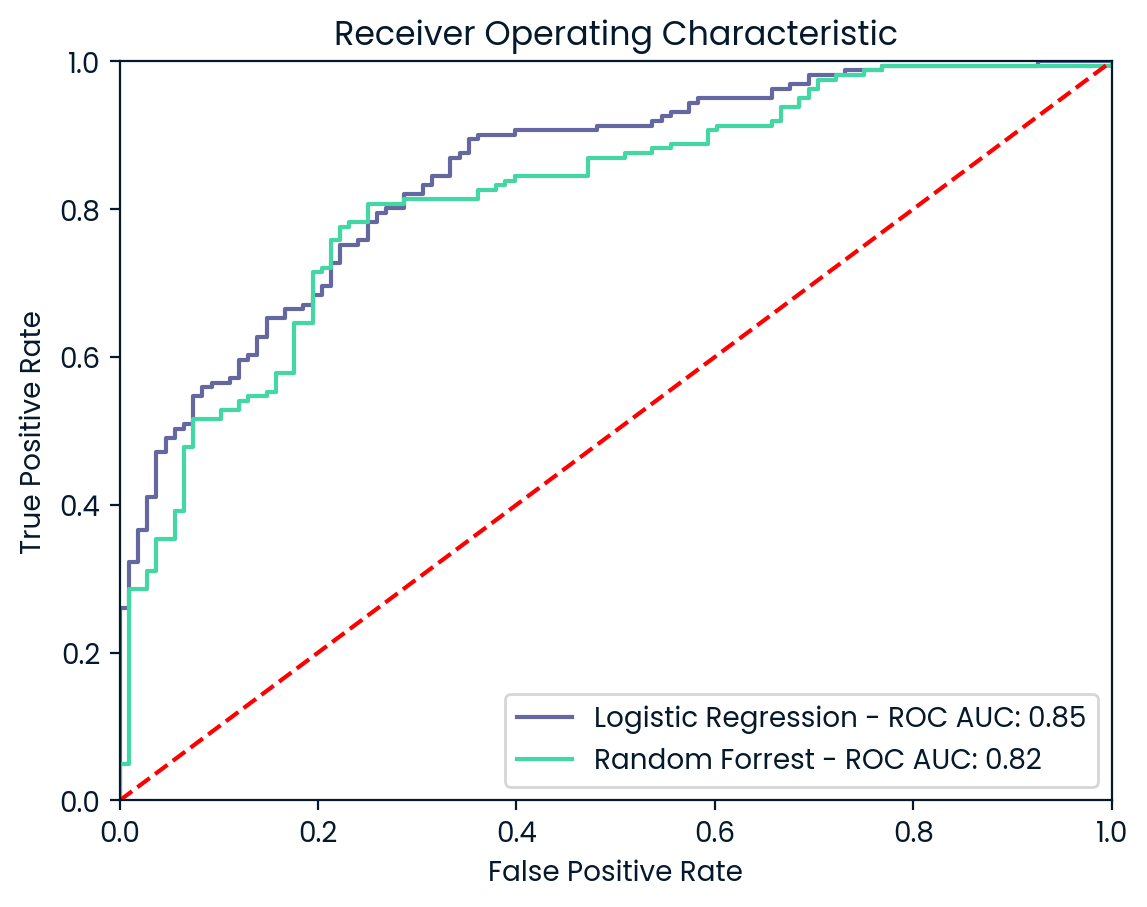

In [31]:
#ROC AUC curve to compare models
probs_lg = lg_grid.predict_proba(X_test)[:,1]
fpr_lg, tpr_lg, threshold_lg = roc_curve(y_test, probs_lg)
roc_auc_lg = roc_auc_score(y_test, probs_lg)

probs_rf = rf_grid.predict_proba(X_ted)[:,1]
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_ted, probs_rf)
roc_auc_rf = roc_auc_score(y_ted, probs_rf)

plt.plot(fpr_lg, tpr_lg, label = f'Logistic Regression - ROC AUC: {roc_auc_lg:.2f}')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forrest - ROC AUC: {roc_auc_rf:.2f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

# Summary

After data cleaning and preprocessing Data Science team trained two classification models to predict recipes generating high traffic on company website. 3 different KPI metrics were chosen (Recall, Precision and F-1 Score) to asses models' performance from different perspectives. Logistic Regression model performed better than Random Forrest Classifier, meeting set criteria of 80% in all cosen KPIs.


Recommendations:
- after deployment, performance of the model should be monitored and tuned if needed. It should be evaluated based on chosen KPI metrics. 
- information gathered in the future should be used to improve model's performance.
- data should be gathered more carefully - many extreme outliers indicate errors during data collection, which result in bias and loss of valuable information.
- data indicate that potato, pork and vegetable categories in almost every case generate high traffic, so I recommend displaying them more often on the home page. On the other hand beverages and breakfasts are not very popular, so should be avoided as home page recipes.
- it seems that more popular are recipies with larger number of servings (4 or 6) - to cater the needs of our visitors we can publish more recipes with higher number of servings or create calculator, that will quickly produce the recipe with desired number of servings